In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import os
from scipy import stats

from toarray import ToArray
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction import FeatureHasher

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

import sklearn.metrics
import pickle
import optuna
import warnings
%matplotlib inline

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#初期設定
random_state = 1
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

In [3]:
#データ読み込み
file_dir = os.getcwd()
file_path_train = os.path.join(file_dir, 'train.csv')
file_path_test = os.path.join(file_dir, 'test.csv')

#学習用データ
data_train = pd.read_csv(file_path_train, parse_dates = ['listing_at'], encoding = 'utf-8', dtype = {'category_class':'int'})

#検証用データ
data_test = pd.read_csv(file_path_test, parse_dates = ['listing_at'], encoding = 'utf-8')

# 1. データ分析/可視化

#### 最初にtrain, testのデータに大きな傾向の違いがないか確認しておく。

In [4]:
print('学習用データ')
display(data_train.head())
print('学習用データは{}行{}列です。'.format(data_train.shape[0], data_train.shape[1]))
print()
print('検証用データ')
display(data_test.head())
print('検証用データは{}行{}列です。'.format(data_test.shape[0], data_test.shape[1]))


学習用データ


,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,7966,0,1164,1162,fff,Fair,7,2017-02-01 16:11:18.978516,3ca192bd7558780793444f73366c58d60c9d7775
1,1850,0,1005,1004,fff,Fair,3,2017-02-02 14:42:51.693295,fbaacb960902382e4f6c96f2d8f225c24eecadb4
2,7582,2,944,944,aaa,Fair,5,2017-02-03 01:55:53.406374,785a7925363bf133a7c5413c563f331c5e02cc69
3,6560,0,1068,1067,fff,Fair,7,2017-01-30 23:34:02.268603,f8997252c6e5ae3d950b736e1a81160a2e937a7f
4,7368,3,1407,1407,ddd,Good,15,2017-02-03 13:38:37.845010,ca59bcd3da4daac52f3fcfdc0ab963f65cf421bc


学習用データは700行9列です。

検証用データ


,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,6000,NaN,1006,1006,aaa,Like New,4,2017-02-01 13:13:59.048372,dd01903921ea24941c26a48f2cec24e0bb0e8cc7
1,5532,NaN,1149,1147,fff,Fair,3,2017-02-01 08:19:21.532519,784e9240155834852dff458a730cceb50229df32
2,6797,NaN,1044,1042,ddd,Like New,21,2017-02-02 13:27:40.620084,7c9fe6831f52e30e0ede4f8c54fd9bba673e8d8b
3,3325,NaN,1547,1545,kkk,Like New,20,2017-02-02 20:59:30.470107,54c1792c99a96a96a2881600f0cce1d81061e8b8
4,5447,NaN,1015,1014,ddd,Like New,5,2017-01-30 17:43:31.962058,081be7c370bf9e7b4c6e696276c1b2d57623b26b


検証用データは300行9列です。


In [5]:
#学習用データの欠損値の確認
data_train.isnull().sum()

item_id           0
category_class    0
sold_price        0
price             0
area_name         0
condition         0
size              0
listing_at        0
item_tag_hash     0
dtype: int64

In [6]:
#検証用データの欠損値確認
data_test.isnull().sum()

item_id             0
category_class    300
sold_price          0
price               0
area_name           0
condition           0
size                0
listing_at          0
item_tag_hash       0
dtype: int64

In [7]:
print('学習用データ')
print(data_train.dtypes)

print('\n検証用データ')
print(data_test.dtypes)

学習用データ
item_id                    int64
category_class             int32
sold_price                 int64
price                      int64
area_name                 object
condition                 object
size                       int64
listing_at        datetime64[ns]
item_tag_hash             object
dtype: object

検証用データ
item_id                    int64
category_class           float64
sold_price                 int64
price                      int64
area_name                 object
condition                 object
size                       int64
listing_at        datetime64[ns]
item_tag_hash             object
dtype: object


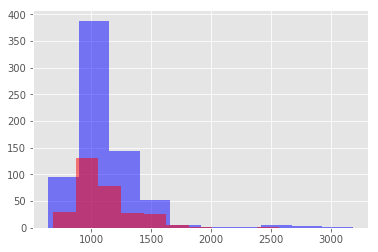

In [8]:
#説明変数中、数値変数はpriceとsold_price
plt.hist(data_train['price'], color = 'b', alpha = 0.5)
plt.hist(data_test['price'], color = 'r', alpha = 0.5)
plt.show()


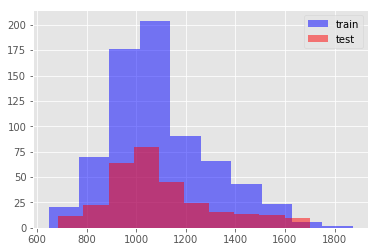

In [9]:
#説明変数中、数値変数はpriceとsold_price
plt.hist(data_train['sold_price'], color = 'b', alpha = 0.5, label = 'train')
plt.hist(data_test['sold_price'], color = 'r', alpha = 0.5, label = 'test')
plt.legend()
plt.show()

In [10]:
#説明変数中のカテゴリ変数はarea_name, condition, size, item_tag_hash
#それぞれのカテゴリ数と、訓練データにしか存在しないカテゴリの水準数を出力する
#結果item_tag_hashはテストデータにしか存在しない値が12件含まれている。

selected_columns = ['area_name', 'condition', 'size', 'item_tag_hash']

check_only_train_dict = {}
for column_name in selected_columns:
    check_only_train_dict[column_name] = len(set(data_test[column_name]) - set(data_train[column_name]))
    
print(check_only_train_dict)

{'area_name': 0, 'condition': 0, 'size': 1, 'item_tag_hash': 12}


train


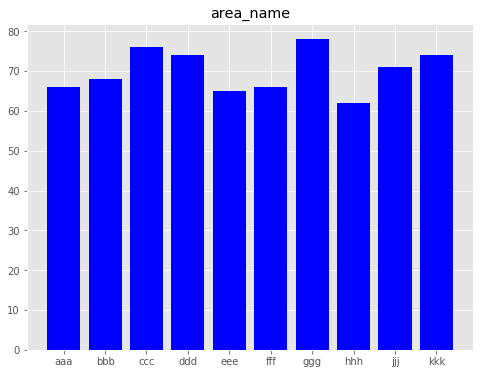

test


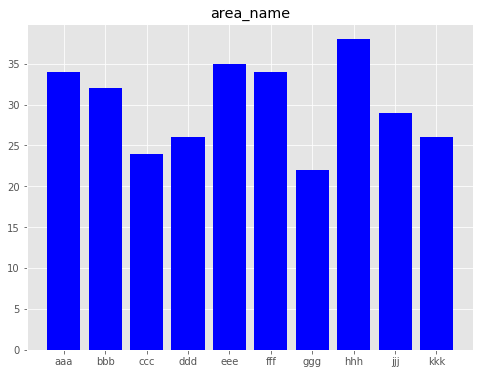

In [11]:
def bar_plot_categ_var(df, var_name, figsize = (8, 6)):
    var_name_dict = df[var_name].value_counts().to_dict()
    var_name_list = []
    count_var_name_list = []
    for k, v in sorted(var_name_dict.items(), key = lambda x : x):
        var_name_list.append(k)
        count_var_name_list.append(v)

    plt.figure(figsize = figsize)
    plt.bar(x = range(len(var_name_list)), height = count_var_name_list, tick_label = var_name_list, color = 'b')
    plt.title(var_name)
    plt.show()

print('train')
bar_plot_categ_var(data_train, 'area_name')

print('test')
bar_plot_categ_var(data_test, 'area_name')


train


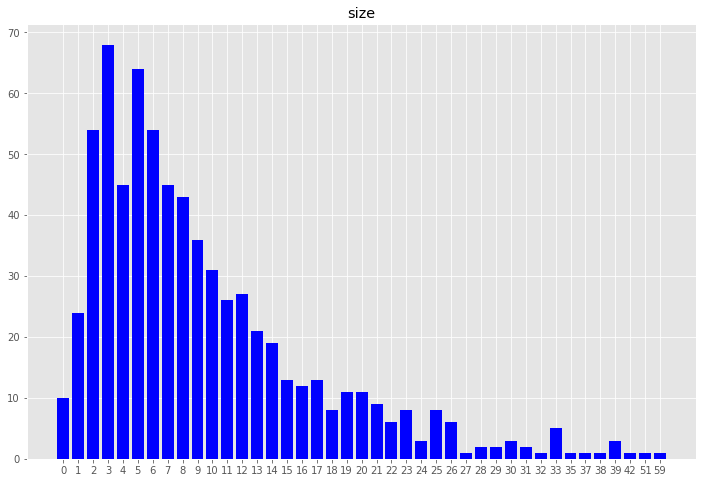

test


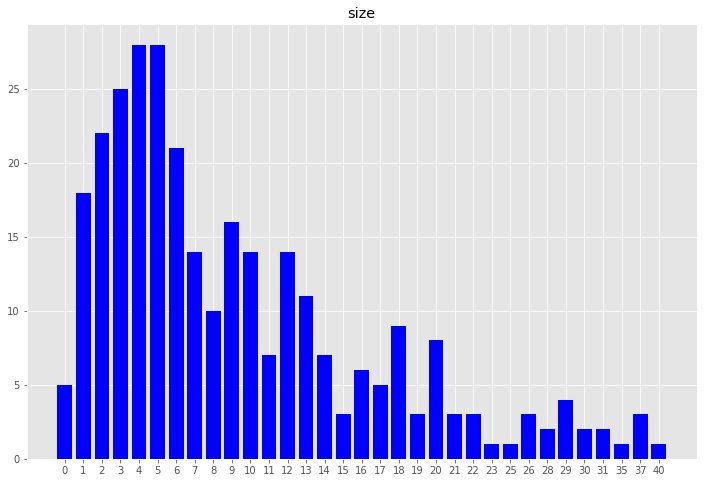

In [12]:

print('train')
bar_plot_categ_var(data_train, 'size', figsize = (12, 8))

print('test')
bar_plot_categ_var(data_test, 'size', figsize = (12, 8))


train


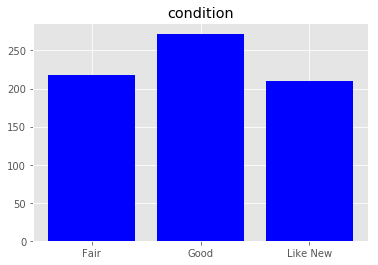

test


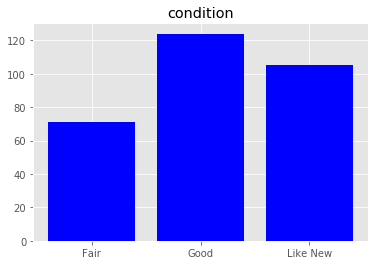

In [13]:

print('train')
bar_plot_categ_var(data_train, 'condition', figsize = (6, 4))

print('test')
bar_plot_categ_var(data_test, 'condition', figsize = (6, 4))


#### 上記の結果、今回のtrain, testデータには大きな違いはないと判断。もしtrain,testのデータ傾向が大きくことなるならadversarial validationを使ってtrain dataからtestデータに似たデータサブセットを作る対処が考えられる。

#### 訓練データ基礎調査

In [14]:
#目的変数の各カテゴリ数確認
#ややアンバランス。理想的には各カテゴリがおなじデータ件数であることです。
#サンプリングなど不均衡データへの対処も検討可能ですが、このぐらいのアンバランスさならデータ件数が少ないこともあり今回はこのまま進めます。
data_train['category_class'].value_counts()

0    226
2    157
1    149
3     86
4     82
Name: category_class, dtype: int64

In [15]:
#item_idに仕様どおり重複がないか確認
#下記結果item_id重複なし。目的変数予測には不要な情報のため、後ほどitem_id列は削除する。

df_item_id = pd.concat([data_train.loc[:, ['item_id']], data_test.loc[:, ['item_id']]], axis = 0)
print('train, test合計のitem_id数：', df_item_id.shape[0])
if len(np.unique(df_item_id['item_id'])) == len(df_item_id['item_id']):
    print('item_idに重複はありません')



train, test合計のitem_id数： 1000
item_idに重複はありません


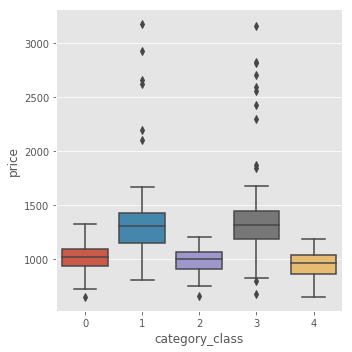

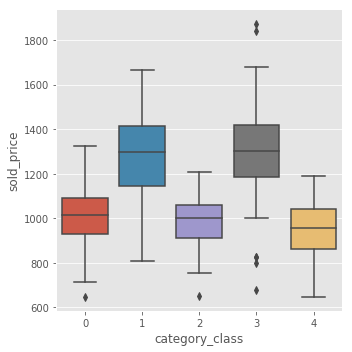

In [16]:
#price, sold_priceの可視化。
#カテゴリ1,3でpriceのほうが値が大幅に大きい点が複数存在することが確認されます。
#カテゴリ[0,2,4]とカテゴリ[1, 3]の2クラス分類ならpriceもしくはsold_priceだけでもそこそこの精度で分類できそう。

sns.catplot(x = 'category_class', y = 'price', kind = 'box', data = data_train);
sns.catplot(x = 'category_class', y = 'sold_price', kind = 'box', data = data_train);

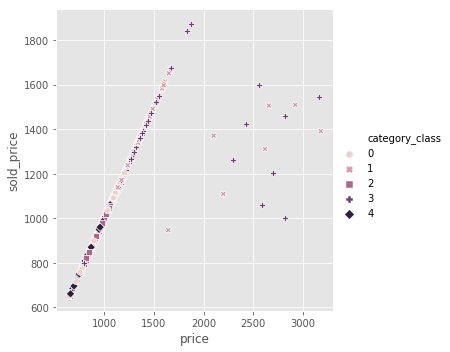

In [17]:
#相関の高そうなsold_priceとpriceの散布図チェック
#結果、カテゴリ1と3はsold_priceとpriceの差が大きいデータが一部存在するがほんどのデータは相関ほぼ1
#よってsold_price列は削除したうえで、sold_priceとpriceの差分を特徴量として作成します。
sns.relplot(x = 'price', y = 'sold_price', data = data_train, hue = 'category_class', legend = 'full', style = 'category_class');

C:\Users\kajiw\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\kajiw\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\kajiw\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\kajiw\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


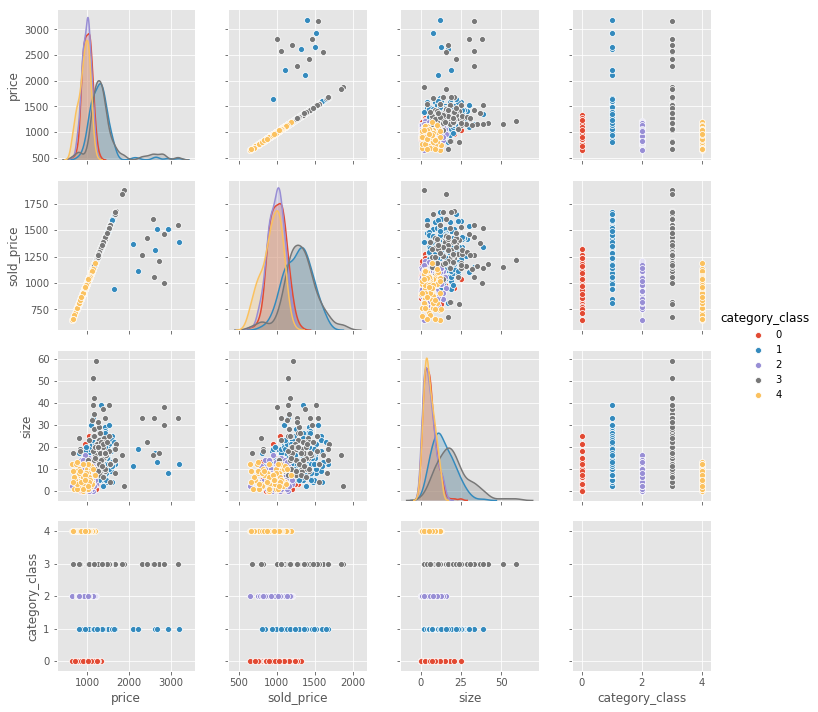

In [18]:
#price, sold_price, size, category_classの関係性をpairplotで確認
sns.pairplot(data_train[['price', 'sold_price', 'size', 'category_class']], hue = 'category_class');

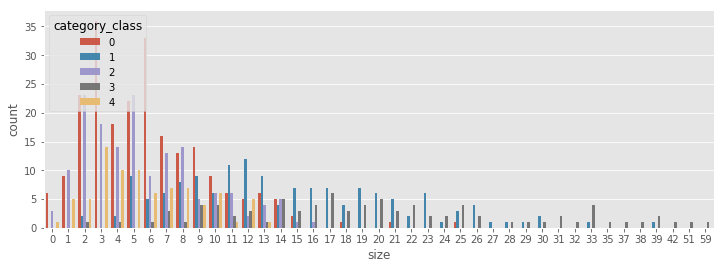

In [19]:
#カテゴリごとにsizeの分布確認
#カテゴリ1,3は他の3カテゴリに比べると大きめ。ただし分布の幅は広く小さいものもある。
#カテゴリ2,4は小さめのサイズに偏っている。
plt.figure(figsize=(12,4))
sns.countplot('size', data = data_train, hue='category_class');

area_name,aaa,bbb,ccc,ddd,eee,fff,ggg,hhh,jjj,kkk
category_class,,,,,,,,,,
0,0.101770,0.119469,0.168142,0.106195,0.110619,0.115044,0.084071,0.053097,0.057522,0.084071
1,0.053691,0.080537,0.067114,0.087248,0.073826,0.100671,0.093960,0.107383,0.154362,0.181208
2,0.114650,0.076433,0.070064,0.146497,0.031847,0.076433,0.133758,0.095541,0.146497,0.108280
3,0.069767,0.046512,0.058140,0.058140,0.081395,0.058140,0.186047,0.197674,0.127907,0.116279
4,0.134146,0.158537,0.146341,0.109756,0.207317,0.097561,0.097561,0.024390,0.012195,0.012195


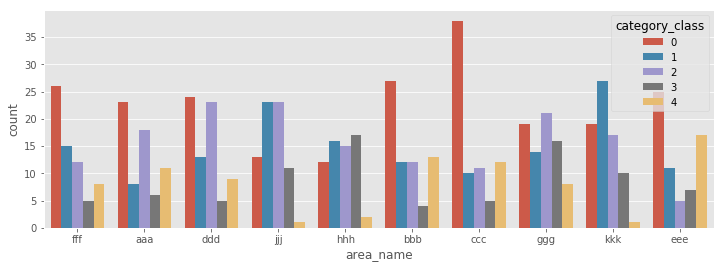

In [20]:
#カテゴリクラスとarea_nameの関係調査。
#下記結果、price等では見分けのつきにくかったカテゴリにもやや違いが出ている。

#カテゴリクラス、area_nameのクロス集計（各カテゴリの和が1になるように比率で表してます）
display(pd.crosstab(index = data_train['category_class'], columns = data_train['area_name']).apply(lambda x : x / x.sum(), axis = 1))

#カテゴリごとのarea_name分布可視化
plt.figure(figsize=(12,4))
sns.countplot('area_name', data = data_train, hue='category_class');

condition,Fair,Good,Like New
category_class,,,
0,0.500000,0.336283,0.163717
1,0.073826,0.389262,0.536913
2,0.184713,0.433121,0.382166
3,0.337209,0.476744,0.186047
4,0.439024,0.353659,0.207317


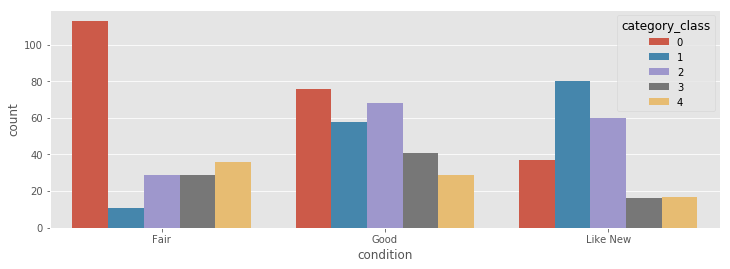

In [21]:
#カテゴリクラスとconditionの関係調査。
#priceやsizeでは見分けにくそうなカテゴリ1と3との違いはconditionに表れている。

#カテゴリクラス、conditionのクロス集計（各カテゴリの和が1になるように比率で表してます）
display(pd.crosstab(index = data_train['category_class'], columns = data_train['condition']).apply(lambda x : x / x.sum(), axis = 1))

#カテゴリごとのcondition分布可視化
plt.figure(figsize=(12,4))
sns.countplot('condition', data = data_train, hue='category_class');

# 2. 特徴抽出 / 特徴エンジニアリング

- sold_price, priceはほとんどのデータポイントで強く相関しているため片方を削除。
- 一部データポイントではsold_priceとpriceの差が有用な情報になりそうなので差分変数作成。
- priceは対数変換実施。
- 日付変数からlistingの月、時間、曜日を抽出
- item_tag_hashはテストデータにしかない値が12件存在したことから、高い頻度で新規の値が追加される変数だと考えられます。  
そのためfeature hashingというテクニックを使用します。

In [22]:
#まず予測に不要なitem_id削除。
data_train = data_train.drop(['item_id'], axis = 1)
data_test = data_test.drop(['item_id'], axis = 1)

In [23]:
#price,sold_priceの差分変数作成
data_train['price_diff'] = data_train['sold_price'] - data_train['price']
data_train.drop(['sold_price'], axis = 1, inplace = True)

#price_diffの統計量をカテゴリごとに確認
display(data_train.groupby('category_class')['price_diff'].describe())

,count,mean,std,min,25%,50%,75%,max
category_class,,,,,,,,
0,226.0,1.013274,1.026234,-1.0,0.0,1.0,2.0,4.0
1,149.0,-54.080537,260.147477,-1790.0,0.0,1.0,2.0,3.0
2,157.0,1.012739,1.049953,-2.0,0.0,1.0,2.0,3.0
3,86.0,-124.848837,405.676386,-1815.0,0.0,1.0,2.0,3.0
4,82.0,0.914634,1.044695,-2.0,0.0,1.0,1.0,3.0


#### 日付データからの特徴抽出

In [24]:
#月の抽出
#訓練、テストデータともに1,2月しかありませんが季節性はありそうなので作成しました
data_train['listing_month'] = data_train['listing_at'].map(lambda x : x.month)

#時間の抽出
data_train['listing_hour'] = data_train['listing_at'].map(lambda x : x.hour)

#曜日の抽出。weekday()の結果は0が月曜日
data_train['listing_day_of_the_week'] = data_train['listing_at'].map(lambda x : x.weekday())

#特徴抽出後のlisting_atは不要なので削除
data_train.drop(['listing_at'], axis = 1, inplace = True)

listing_month,1,2
category_class,,
0,90,136
1,87,62
2,90,67
3,12,74
4,60,22


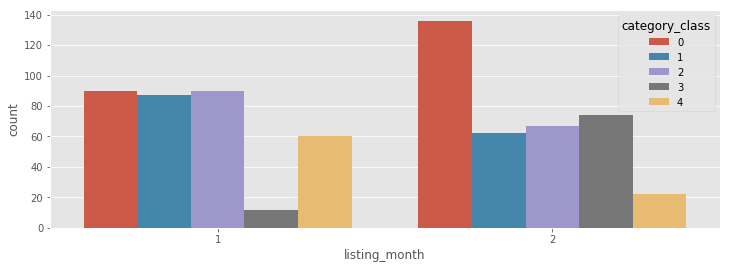

In [25]:
#月別のカテゴリ数確認
#カテゴリ3は2月に急に増えている。カテゴリ4は逆に2月に急に少なくなっている。
display(pd.crosstab(index = data_train['category_class'], columns = data_train['listing_month']))
plt.figure(figsize=(12,4))
sns.countplot('listing_month', data = data_train, hue='category_class');

listing_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
category_class,,,,,,,,,,,,,,,,,,,,,,,,
0,0.048673,0.022124,0.061947,0.022124,0.035398,0.044248,0.035398,0.039823,0.035398,0.017699,0.026549,0.044248,0.035398,0.039823,0.039823,0.048673,0.061947,0.039823,0.075221,0.066372,0.039823,0.039823,0.044248,0.035398
1,0.046980,0.033557,0.026846,0.053691,0.053691,0.060403,0.040268,0.067114,0.020134,0.060403,0.026846,0.040268,0.046980,0.046980,0.080537,0.040268,0.033557,0.046980,0.040268,0.026846,0.020134,0.033557,0.026846,0.026846
2,0.019108,0.038217,0.082803,0.038217,0.031847,0.057325,0.044586,0.057325,0.038217,0.050955,0.044586,0.031847,0.031847,0.038217,0.050955,0.025478,0.044586,0.044586,0.025478,0.038217,0.025478,0.050955,0.044586,0.044586
3,0.058140,0.046512,0.069767,0.058140,0.046512,0.011628,0.011628,0.023256,0.034884,0.034884,0.081395,0.034884,0.058140,0.058140,0.023256,0.034884,0.081395,0.023256,0.023256,0.034884,0.069767,0.034884,0.011628,0.034884
4,0.012195,0.024390,0.048780,0.036585,0.060976,0.036585,0.048780,0.036585,0.012195,0.073171,0.036585,0.060976,0.036585,0.060976,0.048780,0.036585,0.036585,0.060976,0.000000,0.024390,0.048780,0.036585,0.036585,0.085366


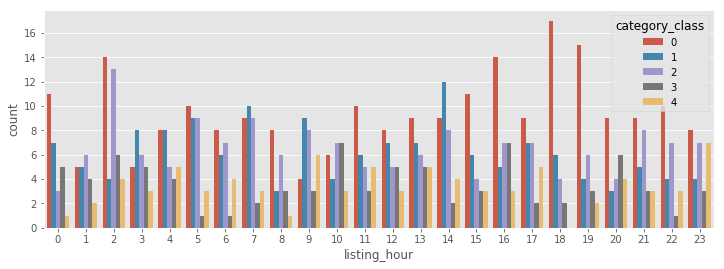

In [26]:
#listing時間とカテゴリの関係調査
display(pd.crosstab(index = data_train['category_class'], columns = data_train['listing_hour']).apply(lambda x : x / x.sum(), axis = 1))
plt.figure(figsize=(12,4))
sns.countplot('listing_hour', data = data_train, hue='category_class');

listing_day_of_the_week,0,1,2,3,4,5,6
category_class,,,,,,,
0,0.141593,0.176991,0.287611,0.199115,0.110619,0.017699,0.066372
1,0.248322,0.261745,0.228188,0.134228,0.046980,0.026846,0.053691
2,0.184713,0.286624,0.210191,0.146497,0.070064,0.019108,0.082803
3,0.034884,0.104651,0.325581,0.313953,0.162791,0.034884,0.023256
4,0.243902,0.304878,0.158537,0.097561,0.012195,0.012195,0.170732


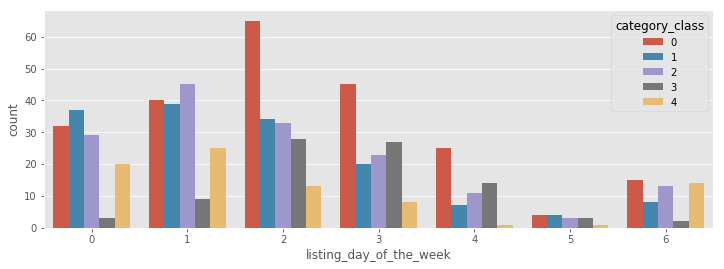

In [27]:
#listing曜日とカテゴリの関係調査
display(pd.crosstab(index = data_train['category_class'], columns = data_train['listing_day_of_the_week']).apply(lambda x : x / x.sum(), axis = 1))
plt.figure(figsize=(12,4))
sns.countplot('listing_day_of_the_week', data = data_train, hue='category_class');

In [28]:
#時間帯の影響がいまいち分かりずらいので時間をビン化する
#ドメイン知識があれば境界値の決め方を検討したいが、ここでは簡易的に0-6時、6-12時、12-18時、18-24時の4カテゴリにビン化する。
listing_hour_bin = pd.cut(data_train['listing_hour'], bins = [0, 6, 12, 18, 24], labels = ['midnight', 'morning', 'afternoon', 'night'])

#正しくビン化できているか確認
#問題なくビン化できてること確認
display(pd.concat([data_train['listing_hour'], listing_hour_bin], axis = 1).head(10))

#代入
data_train['listing_hour'] = listing_hour_bin

,listing_hour,listing_hour
0,16,afternoon
1,14,afternoon
2,1,midnight
3,23,night
4,13,afternoon
5,19,night
6,14,afternoon
7,14,afternoon
8,15,afternoon
9,14,afternoon


In [29]:
data_train.head()

,category_class,price,area_name,condition,size,item_tag_hash,price_diff,listing_month,listing_hour,listing_day_of_the_week
0,0,1162,fff,Fair,7,3ca192bd7558780793444f73366c58d60c9d7775,2,2,afternoon,2
1,0,1004,fff,Fair,3,fbaacb960902382e4f6c96f2d8f225c24eecadb4,1,2,afternoon,3
2,2,944,aaa,Fair,5,785a7925363bf133a7c5413c563f331c5e02cc69,0,2,midnight,4
3,0,1067,fff,Fair,7,f8997252c6e5ae3d950b736e1a81160a2e937a7f,1,1,night,0
4,3,1407,ddd,Good,15,ca59bcd3da4daac52f3fcfdc0ab963f65cf421bc,0,2,afternoon,4


#### 他のカテゴリ変数（area name, condition)前処理

In [30]:
#ダミー変数化した際に変数名を判別しやすくするために、カテゴリ名変換
mapping_dict_month = {1: 'january', 2:'february'}
mapping_dict_day_of_the_week = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'tursday', 4: 'friday', 5: 'saturday', 6: 'sunday'}
data_train['listing_month'] = data_train['listing_month'].map(mapping_dict_month)
data_train['listing_day_of_the_week'] = data_train['listing_day_of_the_week'].map(mapping_dict_day_of_the_week)


#ダミー変数化する変数名をここで指定
get_dummy_col = ['area_name', 'condition', 'listing_hour', 'listing_month', 'listing_day_of_the_week']

#get_dummiesの引数にdrop_first = Trueを設定することでダミー変数化されたarea_name, condition,
#listing_hour, listing_month, listing_day_of_the_weekそれぞれの中から最初の1列削除しておく。
#これは情報の重複を避けるため。
#例えばconditionであればcondition_Fair, condition_Good, condition_Like Newの3変数がありますが、
#3変数中の2変数が決まれば、もう1変数は自動的に決まるためです。

data_train = pd.get_dummies(data_train, drop_first = True, columns = get_dummy_col)
display(data_train.head())
print('ダミー変数化後のデータ件数は{}行、{}列です。'.format(data_train.shape[0], data_train.shape[1]))


,category_class,price,size,item_tag_hash,price_diff,area_name_bbb,area_name_ccc,area_name_ddd,area_name_eee,area_name_fff,area_name_ggg,area_name_hhh,area_name_jjj,area_name_kkk,condition_Good,condition_Like New,listing_hour_morning,listing_hour_afternoon,listing_hour_night,listing_month_january,listing_day_of_the_week_monday,listing_day_of_the_week_saturday,listing_day_of_the_week_sunday,listing_day_of_the_week_tuesday,listing_day_of_the_week_tursday,listing_day_of_the_week_wednesday
0,0,1162,7,3ca192bd7558780793444f73366c58d60c9d7775,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,1004,3,fbaacb960902382e4f6c96f2d8f225c24eecadb4,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2,944,5,785a7925363bf133a7c5413c563f331c5e02cc69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1067,7,f8997252c6e5ae3d950b736e1a81160a2e937a7f,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
4,3,1407,15,ca59bcd3da4daac52f3fcfdc0ab963f65cf421bc,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


ダミー変数化後のデータ件数は700行、26列です。


#### item_tag_hash列の前処理

##### item_tag_hash列はテストデータにしかない値が12件存在している。またカテゴリ数は188と多いため、one-hot-encodingでは以下の点で不都合。

1. 訓練データにないカテゴリ値がテストデータに入っていると推論時にエラーになる。
2. カテゴリ数が多めのため、今回のケースだと187変数になってしまい、  
データ件数に比較して変数の数が増えすぎてしまい、おそらくは精度を下げる。

##### よって別法を検討します。ここではfeature hashingを採用しました。

##### feature hashingでは何次元のハッシュにするか決める必要があります。決め方は2ステップで決めました。
1. 次元を変えながらすべての値が0の次元数を求めました。すべての値が0の次元が多いということは、  
今回のデータには不必要に大きな次元を指定してしまっていると解釈することができます。ここでまずざっくりと必要次元数の目安をつけました。  
<br>
2. 1で求めたおおよその次元数周辺で、予測精度を指標として一番よい次元数を決定しました。

In [31]:
#ここから先はtrainデータをtrain, validationデータにさらに分割する
df_X = data_train.drop(['category_class'], axis = 1)
y = data_train['category_class']

#訓練、検証データに分割。
df_X_train, df_X_valid, s_y_train, s_y_valid = train_test_split(df_X, y, random_state = random_state, stratify = y, test_size = 0.2)

In [32]:
#インデックス振りなおし
df_X_train = df_X_train.reset_index(drop = True)
df_X_valid = df_X_valid.reset_index(drop = True)
s_y_train = s_y_train.reset_index(drop = True)
s_y_valid = s_y_valid.reset_index(drop = True)

In [33]:
#下記ではfeature hashing結果、全ての値が0になる列数をざっくり確認。
#0の列が多い場合、次元が大きすぎると判断する。
#下記の結果5~13次元ぐらいで次元数を振って、精度を指標に最適なfeature hashing次元数を決定することとしました。
n_dim_list = [3, 5, 10, 15,  20, 30, 40, 50]
count_std_0_dict = {}
for n_dim in n_dim_list: 
    h = FeatureHasher(n_features = n_dim, input_type = 'string')
    hash_feature = h.fit_transform(df_X_train['item_tag_hash'])

    #標準偏差が0の列数を求める
    count_std_0 = (hash_feature.toarray().std(axis = 0) == 0).sum()    
    count_std_0_dict[f'n_dim_{n_dim}'] = count_std_0
    
print(count_std_0_dict)




{'n_dim_3': 0, 'n_dim_5': 0, 'n_dim_10': 3, 'n_dim_15': 6, 'n_dim_20': 9, 'n_dim_30': 19, 'n_dim_40': 25, 'n_dim_50': 38}


In [34]:
verbose = 3 #grid search中の精度を確認したいのでverboseを設定

#パイプライン構築
#処理の流れはfeature hashing→疎行列を密行列に変換→ランダムフォレストでクラス分類
#疎行列→密行列に変換するtransformメソッドをもつ自作クラス使用
steps = [
    ('hasher', FeatureHasher(input_type = 'string')),
    ('toarray', ToArray()), #自作クラス。
    ('rf', RandomForestClassifier(random_state = random_state))
]

pipeline = Pipeline(steps = steps)

#以下グリッドサーチで精度を指標に最適なfeature hashing次元数を探索する
#この際の説明変数はfeature hashing後のitem_tag_hashのみとする。（他の変数の影響を排除して判断したいため）
#ランダムフォレストのパラメータは固定にする。ここでの目的は下記n_featuresの探索であって、
#ランダムフォレストの精度を高めたいわけではないため。

param_grid = {
    'hasher__n_features':[5, 6, 7, 8, 9, 10, 11, 12, 13],
    'rf__max_depth':[6], 
    'rf__n_estimators':[500]
    
}


clf = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv = 5, #デフォルトで層化k分割交差検証
    scoring = 'f1_macro', #評価指標は課題に合わせました。
    verbose = verbose
)


#item_tag_hash列のみ取得し、item_tag_hash列→feature hashingした特徴量で目的変数をどこまで分類できるか、
#その精度を指標として次元数決定。
X_hash_train = df_X_train['item_tag_hash'].values
y_hash_train = s_y_train.values

clf.fit(X_hash_train, s_y_train)    



Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500, score=0.7553444556791372, total=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500, score=0.5002196564493662, total=   0.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500, score=0.571607079470956, total=   0.9s
[CV] hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500, score=0.6307360301247515, total=   0.7s
[CV] hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=5, rf__max_depth=6, rf__n_estimators=500, score=0.6722533583706486, total=   0.7s
[CV] hasher__n_features=6, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=6, rf__max_depth=6, rf__n_estimators=500, score=0.6589382194033357, total=   0.8s
[CV] hasher__n_features=6, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=6, rf__max_depth=6, rf__n_estimators=500, score=0.5933973088379723, total=   0.7s
[CV] hasher__n_features=6, rf__max_depth=6, rf__n_estimators=500 .....
[CV]  hasher__n_features=6, rf__max_dept

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   33.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('hasher', FeatureHasher(alternate_sign=True, dtype=<class 'numpy.float64'>,
       input_type='string', n_features=1048576, non_negative=False)), ('toarray', ToArray()), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_feature...estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hasher__n_features': [5, 6, 7, 8, 9, 10, 11, 12, 13], 'rf__max_depth': [6], 'rf__n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=3)

In [35]:
#最適な次元数確認
print(clf.best_params_['hasher__n_features'])

11


##### 上記結果、ベストな次元数は11。出力されたログで各次元数ごとの精度を確認すると9-11くらいまではあまり変わらない。  <br>ここでは11でOKとする。

In [36]:
#feature hasing次元数設定
n_dim = 11

#変換実施
hasher = FeatureHasher(n_features = n_dim, input_type = 'string')
hash_arr_train = hasher.fit_transform(df_X_train['item_tag_hash']).toarray()
hash_arr_valid = hasher.transform(df_X_valid['item_tag_hash']).toarray()

#feature hashing後の列に名前をつける
col_names = []
for i in range(n_dim):
    col_name = 'item_tag_hash_{}'.format(i)
    col_names.append(col_name)
df_hash_train = pd.DataFrame(hash_arr_train, columns = col_names)
df_hash_valid = pd.DataFrame(hash_arr_valid, columns = col_names)

#確認
display(df_hash_train.head())
display(df_hash_valid.head())

,item_tag_hash_0,item_tag_hash_1,item_tag_hash_2,item_tag_hash_3,item_tag_hash_4,item_tag_hash_5,item_tag_hash_6,item_tag_hash_7,item_tag_hash_8,item_tag_hash_9,item_tag_hash_10
0,-2.0,3.0,0.0,0.0,3.0,2.0,4.0,0.0,2.0,0.0,-2.0
1,-5.0,3.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,-2.0,5.0
2,-5.0,4.0,1.0,0.0,1.0,4.0,3.0,0.0,3.0,-1.0,2.0
3,-5.0,4.0,1.0,0.0,1.0,4.0,3.0,0.0,3.0,-1.0,2.0
4,-4.0,1.0,4.0,0.0,3.0,2.0,4.0,0.0,2.0,1.0,3.0


,item_tag_hash_0,item_tag_hash_1,item_tag_hash_2,item_tag_hash_3,item_tag_hash_4,item_tag_hash_5,item_tag_hash_6,item_tag_hash_7,item_tag_hash_8,item_tag_hash_9,item_tag_hash_10
0,-2.0,3.0,0.0,0.0,3.0,2.0,4.0,0.0,2.0,0.0,-2.0
1,-7.0,1.0,1.0,0.0,-1.0,1.0,2.0,0.0,2.0,2.0,5.0
2,-3.0,2.0,1.0,0.0,0.0,4.0,2.0,0.0,3.0,2.0,3.0
3,-6.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0
4,-3.0,6.0,2.0,0.0,-3.0,5.0,2.0,0.0,0.0,0.0,5.0


In [37]:
#item_tag_hash_3, item_tag_hash_7はすべての値が0のためあとで削除する。
df_hash_train.apply(abs).sum(axis = 0)

item_tag_hash_0     1399.0
item_tag_hash_1     1411.0
item_tag_hash_2      998.0
item_tag_hash_3        0.0
item_tag_hash_4      994.0
item_tag_hash_5     1592.0
item_tag_hash_6     1678.0
item_tag_hash_7        0.0
item_tag_hash_8     1409.0
item_tag_hash_9      967.0
item_tag_hash_10    1660.0
dtype: float64

In [38]:
#ハッシュ化したitem_tag_hashを連結
df_X_train = pd.concat([df_X_train, df_hash_train], axis = 1).drop(['item_tag_hash', 'item_tag_hash_3', 'item_tag_hash_7'], axis = 1)
df_X_valid = pd.concat([df_X_valid, df_hash_valid], axis = 1).drop(['item_tag_hash', 'item_tag_hash_3', 'item_tag_hash_7'], axis = 1)
print(df_X_train.shape)
print(df_X_valid.shape)

(560, 33)
(140, 33)


In [39]:
display(df_X_train.head())
display(df_X_valid.head())

,price,size,price_diff,area_name_bbb,area_name_ccc,area_name_ddd,area_name_eee,area_name_fff,area_name_ggg,area_name_hhh,area_name_jjj,area_name_kkk,condition_Good,condition_Like New,listing_hour_morning,listing_hour_afternoon,listing_hour_night,listing_month_january,listing_day_of_the_week_monday,listing_day_of_the_week_saturday,listing_day_of_the_week_sunday,listing_day_of_the_week_tuesday,listing_day_of_the_week_tursday,listing_day_of_the_week_wednesday,item_tag_hash_0,item_tag_hash_1,item_tag_hash_2,item_tag_hash_4,item_tag_hash_5,item_tag_hash_6,item_tag_hash_8,item_tag_hash_9,item_tag_hash_10
0,1512,21,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,-2.0,3.0,0.0,3.0,2.0,4.0,2.0,0.0,-2.0
1,1051,5,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,-5.0,3.0,1.0,1.0,3.0,1.0,1.0,-2.0,5.0
2,1049,2,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,-5.0,4.0,1.0,1.0,4.0,3.0,3.0,-1.0,2.0
3,1028,4,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,-5.0,4.0,1.0,1.0,4.0,3.0,3.0,-1.0,2.0
4,1233,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,-4.0,1.0,4.0,3.0,2.0,4.0,2.0,1.0,3.0


,price,size,price_diff,area_name_bbb,area_name_ccc,area_name_ddd,area_name_eee,area_name_fff,area_name_ggg,area_name_hhh,area_name_jjj,area_name_kkk,condition_Good,condition_Like New,listing_hour_morning,listing_hour_afternoon,listing_hour_night,listing_month_january,listing_day_of_the_week_monday,listing_day_of_the_week_saturday,listing_day_of_the_week_sunday,listing_day_of_the_week_tuesday,listing_day_of_the_week_tursday,listing_day_of_the_week_wednesday,item_tag_hash_0,item_tag_hash_1,item_tag_hash_2,item_tag_hash_4,item_tag_hash_5,item_tag_hash_6,item_tag_hash_8,item_tag_hash_9,item_tag_hash_10
0,1428,27,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,-2.0,3.0,0.0,3.0,2.0,4.0,2.0,0.0,-2.0
1,899,3,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,-7.0,1.0,1.0,-1.0,1.0,2.0,2.0,2.0,5.0
2,1248,19,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,-3.0,2.0,1.0,0.0,4.0,2.0,3.0,2.0,3.0
3,803,5,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,-6.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0
4,1097,8,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,-3.0,6.0,2.0,-3.0,5.0,2.0,0.0,0.0,5.0


# 3. モデル学習

- モデルはLightGBMのシングルモデルとしました。
- チューニングはoptuna使用(公式サンプルをカスタマイズしてます)  https://github.com/pfnet/optuna/blob/master/examples/lightgbm_simple.py 
- チューニングの評価指標はCVにおける平均f1 scoreを計算し、これを最大化することとしました。
- LightGBMのiterationは200と多めに設定したうえで、過学習防止のためにearly stoppingを設定しています。
- 各trialごとにuuidを振ってます。またモデルはuuidと紐づけて保存しています。
- 各trialの結果(f1 score平均値、標準偏差、validationデータに対するf1 score、パラメータ）はデータフレーム化しました。
- 上記データフレームはf1 score平均値で降順ソートし、保存済の上位top5のモデルをload、top5モデル各出力の平均値を最終的なモデル出力としました。

In [40]:
X_train = df_X_train.values
y_train = s_y_train.values
X_valid = df_X_valid.values
y_valid = s_y_valid.values
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(560, 33)
(140, 33)
(560,)
(140,)


In [41]:
import uuid

#各trialにおけるuuidを保存するリスト
trial_uuid_list = []

#各trialにおけるf1score平均値を保存するリスト
f1_score_mean_list = []

#各trialにおけるf1score標準偏差を保存するリスト
f1_score_std_list = []

#各trialにおけるvalidationデータでのf1scoreを保存するリスト
f1_score_valid_list = []

#各trialにおけるパラメータを保存するリスト
params_list = []

def objective(trial):
    skf = StratifiedKFold(n_splits = 20, random_state = random_state)
    
    #各CVごとのf1 scoreを保存
    f1_score_list = []

    for idx_train, idx_test in skf.split(X_train, y_train):
        
        dtrain = lgb.Dataset(X_train[idx_train], label = y_train[idx_train])
        eval_data = lgb.Dataset(X_train[idx_test], label = y_train[idx_test], reference = dtrain)

        # 試行にUUIDを設定
        trial_uuid = str(uuid.uuid4())
        trial.set_user_attr("uuid", trial_uuid)

        param = {
            'objective': 'multiclass',
            'num_class': 5,#目的変数のカテゴリ数
            'boosting_type': 'gbdt', #他のboosting typeもあるが今回はgbdtに限定
            'num_leaves': trial.suggest_int('num_leaves', 30, 100),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'verbosity': -1,
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.08, 0.2),
            'metric': 'multi_logloss', #学習の評価指標
            'seed': random_state
        }

        #学習
        gbm = lgb.train(
            param, dtrain,
            num_boost_round = 200, #ブースティング繰り返し回数の最大値を200に設定
            valid_sets = eval_data, #CVごとにtrainに使われていないデータを評価用データとする。
            early_stopping_rounds = 3, #3回続けてlossに大きな変化がなければ学習ストップ
            verbose_eval = 50 #ログ出力設定
        )
        
        #各クラス予測確率
        y_pred_proba = gbm.predict(X_train[idx_test])
        
        #確率→予測ラベルへ変換
        y_pred = np.argmax(y_pred_proba, axis = 1)
        
        #f1 score記録
        f1_score = sklearn.metrics.f1_score(y_true = y_train[idx_test], y_pred = y_pred, average = 'macro')
        f1_score_list.append(f1_score)
    
    trial_uuid_list.append(trial_uuid)
    
    #CVにおける平均f1 score計算
    f1_score_mean = np.mean(f1_score_list)
    f1_score_mean_list.append(f1_score_mean)
    
    #CVにおけるf1 scoreの標準偏差計算
    f1_score_std = np.std(f1_score_list)
    f1_score_std_list.append(f1_score_std)
    
    print('f1 score list : ', f1_score_list)
    print('f1 score std : ', f1_score_std)
    
    #validationデータに対するf1 score計算
    y_pred_proba_valid = gbm.predict(X_valid)
    y_pred_valid = np.argmax(y_pred_proba_valid, axis = 1)
    f1_score_valid = sklearn.metrics.f1_score(y_true = y_valid, y_pred = y_pred_valid, average = 'macro')
    print('f1 score valid : ', f1_score_valid)
    f1_score_valid_list.append(f1_score_valid)
    
    #トライしたパラメータ格納
    print('params : ', param)
    params_list.append(param)

    
    # モデルの保存、あとでloadして使用するのでuuidをファイル名に振っておく
    if not os.path.exists("lgb_output"):
        os.mkdir("lgb_output")
    with open("lgb_output/"+f"{trial_uuid}.pkl", "wb") as fp:
        pickle.dump(gbm, fp)
    
    return f1_score_mean #この数値を最大化するパラメータを探索

#チューニング実施
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100) #n_trialsはパラメータ探索を試行する回数

#ベストチューニング結果出力
print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.668438
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.573705
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.848427
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.790337
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.786981
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.652298
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.407448
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.284049
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 1.07859
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 1.0972
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.865278
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.348772
[100]	valid_0's multi_logloss: 0.129911
[150]	valid_0's multi_logloss: 0.0680582
Early stopping, best iteration is:
[183]	valid_0's multi_logloss: 0.0453583
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.776407
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.74069


C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.852151
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.904256
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.886466
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.641545
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.627958
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.559371
[100]	valid_0's multi_logloss: 0.348379
Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.28768
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.58398
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.473628
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.650043
Early stopping, best iteration

[I 2019-10-01 13:39:14,570] Finished trial#0 resulted in value: 0.7400444841349404. Current best value is 0.7400444841349404 with parameters: {'num_leaves': 56, 'max_depth': 5, 'learning_rate': 0.12426968917684246}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.608255
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.596654
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.753001
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.680942
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.773446
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.77125
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.611513
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.609796
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.399995
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.309191
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 1.067

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.73631
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.907048
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.862473
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.613468
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.487636
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.553979
[100]	valid_0's multi_logloss: 0.378174
Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.370863
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.631248
[100]	valid_0's multi_logloss: 0.440977
Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.440309
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss

[I 2019-10-01 13:39:20,037] Finished trial#1 resulted in value: 0.7759275515506165. Current best value is 0.7759275515506165 with parameters: {'num_leaves': 63, 'max_depth': 9, 'learning_rate': 0.0927425996146053}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.658082
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.594189
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.80824
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.822824
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.644204
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.386395
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.314388
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.07586
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.583504
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.836046
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.855873
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.829109
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.592037
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.560516
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.54951
[100]	valid_0's multi_logloss: 0.353575
Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.335646
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.584265
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.528064
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.588301
Early stopping, best iteratio

[I 2019-10-01 13:39:23,795] Finished trial#2 resulted in value: 0.737825393523334. Current best value is 0.7759275515506165 with parameters: {'num_leaves': 63, 'max_depth': 9, 'learning_rate': 0.0927425996146053}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.602428
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.602011
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.707358
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.682741
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.729486
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.724195
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.587698
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.575592
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.436448
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 1.03335
Training until validation scores do

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.7378
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.92549
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.921444
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.556892
[100]	valid_0's multi_logloss: 0.404139
Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.393794
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.456155
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.340461
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.583203
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.477415
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.473352
Early stopping, best iteration 

[I 2019-10-01 13:39:29,078] Finished trial#3 resulted in value: 0.7766091070092618. Current best value is 0.7766091070092618 with parameters: {'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.10844225562582474}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.512134
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.633856
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.608466
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.736132
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.611144
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.300001
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.03261
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.460158
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.77628
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.959868
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.429077
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.380579
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.311004
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.408297
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.350988
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.375358
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.319443
Training until validation scores don't improve for 3 rounds.
Early stoppin

[I 2019-10-01 13:39:32,232] Finished trial#4 resulted in value: 0.7757776551980348. Current best value is 0.7766091070092618 with parameters: {'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.10844225562582474}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.570828
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.55934
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.715194
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.852339
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.583513
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.567675
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.35602
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.249269
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 1.08735
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's 

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.793884
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.809953
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.809953
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.47777
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.454485
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.438973
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.295385
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.479553
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.41168
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.514402
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.4436

[I 2019-10-01 13:39:35,335] Finished trial#5 resulted in value: 0.766261102416675. Current best value is 0.7766091070092618 with parameters: {'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.10844225562582474}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.604359
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.579091
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.719196
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.716275
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.768649
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.765709
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.632055
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.630282
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.394944
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.270203
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 1.04

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.709826
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.922167
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.578462
[100]	valid_0's multi_logloss: 0.402077
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.383627
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.523671
[100]	valid_0's multi_logloss: 0.353537
Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.350049
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.601697
Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.451216
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.516373
Early stopping, best iterat

[I 2019-10-01 13:39:40,270] Finished trial#6 resulted in value: 0.7772087592490068. Current best value is 0.7772087592490068 with parameters: {'num_leaves': 40, 'max_depth': 11, 'learning_rate': 0.09558850222728091}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.470289
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.459126
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.701639
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.75725
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.587826
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.322519
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.02331
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.461873
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.734529
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.843385
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.442009
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.428335
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.415009
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.411825
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.424158
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.38453
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.376734
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.345381
Training until validation scores do

[I 2019-10-01 13:39:43,538] Finished trial#7 resulted in value: 0.7795030276740802. Current best value is 0.7795030276740802 with parameters: {'num_leaves': 34, 'max_depth': 11, 'learning_rate': 0.1869564650980159}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.631478
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.629708
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.774056
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.715507
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.744783
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.728772
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.641548
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.610738
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.423161
Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.314124
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.02

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.743013
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.947963
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.640185
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.497405
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.544281
Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.403362
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.62516
[100]	valid_0's multi_logloss: 0.428784
Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.362552
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.582538
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.4

[I 2019-10-01 13:39:48,791] Finished trial#8 resulted in value: 0.7654831515233991. Current best value is 0.7795030276740802 with parameters: {'num_leaves': 34, 'max_depth': 11, 'learning_rate': 0.1869564650980159}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.634872
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.537446
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.745364
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.667625
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.766219
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.737766
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.639132
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.634791
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.397712
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.28984
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 1.084

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.780208
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.779921
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.882586
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.576494
[100]	valid_0's multi_logloss: 0.402086
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.402086
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.524858
Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.376166
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.66923
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.517141
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.616532
Early stopping, best iteratio

[I 2019-10-01 13:39:53,538] Finished trial#9 resulted in value: 0.7738250431199348. Current best value is 0.7795030276740802 with parameters: {'num_leaves': 34, 'max_depth': 11, 'learning_rate': 0.1869564650980159}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.538948
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.537868
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.691258
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.703276
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.610223
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.306936
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.01818
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.483728
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.748521
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.842725
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.463801
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.428184
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.365568
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.332455
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.526156
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.419063
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.312312
Training until validation scores don't improve for 3 rounds.
[50]	valid_0

[I 2019-10-01 13:39:57,358] Finished trial#10 resulted in value: 0.779889199293998. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.541665
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.701414
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.765797
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.654039
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.323354
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.315494
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.00581
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.410186
Early stopping, best iteration is:
[48]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.742537
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.939884
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.450656
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.39959
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.439583
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.432278
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.459989
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.377765
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.44958
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.351104
Training until validation scores don

[I 2019-10-01 13:40:01,774] Finished trial#11 resulted in value: 0.7661824622745675. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.583087
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.706113
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.72038
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.581528
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.278254
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.220063
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.01766
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.446627
Early stopping, best iteration is:
[48]	valid_0's mul

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.732859
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.883763
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.519404
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.386492
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.343296
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.46923
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.421639
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.428821
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.315643
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

[I 2019-10-01 13:40:06,654] Finished trial#12 resulted in value: 0.7697273400833773. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.5329
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.739785
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.760698
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.541966
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.278091
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.275322
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.03758
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.417833
Early stopping, best iteration is:
[50]	valid_0's mult

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.729533
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.849827
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.466254
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.373089
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.451217
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.368667
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.306
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.605875
f1 score list :  [0

[I 2019-10-01 13:40:10,654] Finished trial#13 resulted in value: 0.7749656116157665. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.558435
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.656279
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.761968
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.613546
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.311511
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.282791
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.01695
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.478208
Early stopping, best iteration is:
[54]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.73898
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.927179
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.522427
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.462003
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.412226
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.315462
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.488734
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.423539
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.421847
Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.261199
Training until validation scores do

[I 2019-10-01 13:40:14,714] Finished trial#14 resulted in value: 0.774442682790206. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.561078
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.486247
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.653215
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.64791
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.775016
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.620347
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.611502
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.337505
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.322771
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.0736
Training until validation scores don'

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.754942
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.93376
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.493283
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.404738
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.478833
Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.347613
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.519051
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.427326
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.511795
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.402512
Training until validation scores do

[I 2019-10-01 13:40:18,468] Finished trial#15 resulted in value: 0.7620883236990047. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.557439
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.635255
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.629928
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.824628
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.617209
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.272867
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.238535
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.04704
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.454342
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.761005
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.872956
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.426885
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.391846
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.363505
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.32747
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.411856
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.304753
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.398007
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.344174
Training until validation scores do

[I 2019-10-01 13:40:22,057] Finished trial#16 resulted in value: 0.7742194014276059. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.600556
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.687702
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.704627
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.616757
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.323878
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.27397
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 1.07121
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.434018
Early stopping, best iteration is:
[57]	valid_0's mul

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.721054
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.840832
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.503133
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.391187
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.440199
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.317915
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.470306
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.361458
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.451594
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.398354
Training until validation scores d

[I 2019-10-01 13:40:25,905] Finished trial#17 resulted in value: 0.7736724870416819. Current best value is 0.779889199293998 with parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.15856620879275884}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.525541
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.520351
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.698063
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.652433
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.651231
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.323736
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.00551
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.540523
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.720406
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.865795
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.41547
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.366873
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.306091
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.29976
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.454335
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.440993
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.487138
Training until validation scores don't improve for 3 rounds.
Early stopping

[I 2019-10-01 13:40:29,073] Finished trial#18 resulted in value: 0.7799184119973593. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.571328
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.656553
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.635897
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.758932
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.582675
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.582675
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.363822
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.310734
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 1.05285
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.722528
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.96822
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.556273
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.449466
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.452392
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.33849
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.547835
Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.422077
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.53238
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.491868
Training until validation scores don'

[I 2019-10-01 13:40:32,967] Finished trial#19 resulted in value: 0.766228112702571. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.728624
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.660437
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.826201
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.824802
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.806444
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.789427
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.653889
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.417686
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.390454
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 1.04692
Training until validation scores do

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.862775
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.872471
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.841871
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.633475
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.566285
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.631366
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.613677
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.557622
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.661569
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.536081
Training until validation scores d

[I 2019-10-01 13:40:35,622] Finished trial#20 resulted in value: 0.7250894771722944. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.480729
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.476502
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.704619
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.769732
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.605788
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.354557
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.01163
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.484622
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.707146
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.952654
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.464242
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.371247
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.362071
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.426806
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.426806
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.380213
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.340878
Training until validation scores don't improve for 3 rounds.
Early stoppi

[I 2019-10-01 13:40:39,460] Finished trial#21 resulted in value: 0.7631486467608758. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.521332
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.467179
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.695065
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.720792
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.632549
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.253697
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.209372
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 1.02288
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.472674
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.70699
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.942646
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.439766
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.401713
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.333712
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.281523
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.429038
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.417028
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.42884
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.347114
Training until validation scores don

[I 2019-10-01 13:40:43,423] Finished trial#22 resulted in value: 0.7797145087454684. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.50588
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.501239
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.660392
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.707194
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.605658
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.288318
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.04631
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.458826
Early stopping, best iteration is:
[47]	valid_0's mul

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.73808
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.941088
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.480507
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.363532
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.359502
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.414812
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.399489
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.421614
Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.320471
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

[I 2019-10-01 13:40:48,480] Finished trial#23 resulted in value: 0.7796929037594673. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.535483
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.457196
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.70703
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.752679
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.617852
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.310814
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.295791
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.05296
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.493506
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.769836
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.967535
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.524842
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.43875
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.37796
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.297491
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.420852
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.381739
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.450733
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.450733
Training until validation scores don

[I 2019-10-01 13:40:52,363] Finished trial#24 resulted in value: 0.775220831971606. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.604935
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.732321
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.698403
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.598524
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.28428
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.04132
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.50457
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.501245
Training until vali

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.728811
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.886495
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.478133
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.43512
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.418894
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.488269
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.421694
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.33516
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's mul

[I 2019-10-01 13:40:55,604] Finished trial#25 resulted in value: 0.7589851342328122. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.568376
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.746709
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.769608
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.623176
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.321704
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.319677
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.03709
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.470292
Early stopping, best iteration is:
[65]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.702628
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.811904
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.483165
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.476659
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.352409
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.316321
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.480266
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.4594
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.422234
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.331404
Training until validation scores don

[I 2019-10-01 13:40:58,983] Finished trial#26 resulted in value: 0.7721903050509862. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.532375
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.508717
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.687493
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.744151
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.605456
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.29223
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.29223
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.04639
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.451442
Early stopping,

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.744708
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.847315
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.480283
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.390579
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.468771
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.424724
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.481482
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.440164
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.435307
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.322817
Training until validation scores d

[I 2019-10-01 13:41:03,100] Finished trial#27 resulted in value: 0.7580372436301228. Current best value is 0.7799184119973593 with parameters: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.1793389100984289}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.549814
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.635022
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.685592
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.653086
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.256428
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.238132
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.01091
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.5596
Training until vali

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.717255
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.96744
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.40696
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.379596
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.357281
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.273178
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.434945
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.421841
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.436423
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.398972
Training until validation scores don

[I 2019-10-01 13:41:06,837] Finished trial#28 resulted in value: 0.7934159887240383. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.523213
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.700505
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.797879
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.600807
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.292364
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.213221
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 1.07292
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.41675
Early stopping, best iteration is:
[51]	valid_0's mul

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.764291
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.873687
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.544166
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.378452
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.332292
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.514211
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.343239
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.30077
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's mu

[I 2019-10-01 13:41:09,820] Finished trial#29 resulted in value: 0.7691551432743383. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.554616
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.499496
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.676995
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.648323
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.738536
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.73672
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.611748
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.608989
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.334757
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.278237
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 1.063

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.73714
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.869932
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.858304
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.541957
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.521963
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.441135
Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.274741
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.538387
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.464318
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.459022
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.409

[I 2019-10-01 13:41:14,224] Finished trial#30 resulted in value: 0.7742298705766197. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.476086
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.476086
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.70797
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.729858
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.568833
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.309154
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.297199
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.02295
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's mul

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.725783
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.998774
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.420372
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.352662
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.347127
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.332389
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.416662
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.411274
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.381529
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.303218
Training until validation scores d

[I 2019-10-01 13:41:17,559] Finished trial#31 resulted in value: 0.7754979669341293. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.542916
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.691325
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.760289
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.579109
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.311647
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 1.05758
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.500729
Training until validation scores don't improve for 3 rou

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.697739
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.906022
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.405852
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.371638
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.402108
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.345364
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.439405
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.439026
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.446473
Training until validation scores don't improve for 3 rounds.
[50]	valid_0

[I 2019-10-01 13:41:21,057] Finished trial#32 resulted in value: 0.7765190037001182. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.606088
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.724722
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.7379
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.609962
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.291117
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.2856
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.00233
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.468777
Early stopping, best iteration is:
[52]	valid_0's multi_

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.739729
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.868623
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.456092
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.410629
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.345989
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.31824
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.417771
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.398088
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.554344
Early stoppin

[I 2019-10-01 13:41:24,544] Finished trial#33 resulted in value: 0.7814514691534815. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.591092
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.719264
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.708239
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.592058
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.33039
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.04221
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.483165
Training until validation scores don't improve for 3 roun

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.729343
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.952989
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.44145
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.378114
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.303744
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.396647
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.344507
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.277838
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.555599
Early stoppin

[I 2019-10-01 13:41:27,970] Finished trial#34 resulted in value: 0.7698355561706954. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.553152
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.435713
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.693558
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.678442
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.713826
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.703328
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.600014
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.5898
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.31286
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.265538
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 1.05693

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.736371
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.958888
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.466866
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.375248
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.396389
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.274611
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.505725
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.436745
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.441888
[100]	valid_0's multi_logloss: 0.275278
Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.2

[I 2019-10-01 13:41:32,266] Finished trial#35 resulted in value: 0.7816505332472825. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.575428
Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.480032
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.733244
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.686892
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.677278
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.600845
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.585147
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.379742
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.304309
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.0661
Training until validation scores don

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.732742
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.987228
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.571404
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.452592
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.455853
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.383696
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.551237
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.387924
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.502506
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.382617
Training until validation scores d

[I 2019-10-01 13:41:36,809] Finished trial#36 resulted in value: 0.7778271465376727. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.539061
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.632624
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.761239
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.628822
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.296739
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.28961
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.05845
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.460715
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.735549
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.959072
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.433803
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.426154
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.357494
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.327159
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.428262
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.40679
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.361533
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.356296
Training until validation scores do

[I 2019-10-01 13:41:39,998] Finished trial#37 resulted in value: 0.7863438659723488. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.560181
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.500689
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.695425
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.70301
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.696601
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.637622
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.336005
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.306432
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.06994
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.742151
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.909017
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.484242
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.427657
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.444884
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.365796
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.499089
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.385133
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.495992
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.490047
Training until validation scores d

[I 2019-10-01 13:41:44,437] Finished trial#38 resulted in value: 0.7698441808449548. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.584747
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.649044
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.734825
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.560668
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.260263
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.230147
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.03821
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.485018
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.727421
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.947621
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.390742
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.317032
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.380368
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.37273
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.492458
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.38952
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.347373
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's

[I 2019-10-01 13:41:47,693] Finished trial#39 resulted in value: 0.7732525511983717. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.593018
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.637566
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.635392
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.754414
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.611657
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.322389
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.293153
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 1.04947
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.479792
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.718014
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.899681
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.537012
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.533147
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.445044
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.334139
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.516624
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.418653
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.450398
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.447177
Training until validation scores d

[I 2019-10-01 13:41:51,633] Finished trial#40 resulted in value: 0.7615843368877424. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.531907
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.654998
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.651069
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.701571
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.632406
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.290461
Early stopping, best iteration is:
[93]	valid_0's multi_logloss: 0.204786
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.02031
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.482624
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.701782
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.974258
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.42292
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.353253
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.353731
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.314541
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.454445
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.445749
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.414911
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.357461
Training until validation scores do

[I 2019-10-01 13:41:55,599] Finished trial#41 resulted in value: 0.7910462208257336. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.531539
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.630643
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.619601
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.725834
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.606152
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.281797
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.18994
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.991905
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.724097
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.966293
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.42
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.359374
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.397656
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.361848
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.462049
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.406728
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.413296
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.343063
Training until validation scores don't

[I 2019-10-01 13:41:59,654] Finished trial#42 resulted in value: 0.7882102107558764. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.615716
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.706967
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.731975
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.619191
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.246306
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.241359
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.02432
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.501182
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.705284
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.955151
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.488567
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.408038
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.35164
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.46243
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.401279
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.427849
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.391382
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's

[I 2019-10-01 13:42:03,660] Finished trial#43 resulted in value: 0.7714855308949736. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.551604
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.68393
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.662487
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.724753
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.620297
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.335896
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.243566
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 1.05058
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.499335
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.741854
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.985526
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.519046
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.433207
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.451827
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.390301
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.534076
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.441297
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.489414
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.364737
Training until validation scores d

[I 2019-10-01 13:42:07,785] Finished trial#44 resulted in value: 0.7782178262054422. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.606863
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.660824
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.638831
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.757914
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.643789
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.290662
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.242216
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.03576
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.501961
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.721113
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.853788
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.489346
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.438649
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.396952
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.320745
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.469555
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.385593
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.447369
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.364886
Training until validation scores d

[I 2019-10-01 13:42:11,815] Finished trial#45 resulted in value: 0.7635361365500685. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.553445
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.544023
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.761743
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.906304
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.579806
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.285695
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.255003
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.0659
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.482448
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.797219
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.796197
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.526232
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.456405
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.338802
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.450719
[100]	valid_0's multi_logloss: 0.336321
Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.333005
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.609784
Training until validation scores don't improve for 3 rounds.
[50]	valid_

[I 2019-10-01 13:42:14,876] Finished trial#46 resulted in value: 0.7525959254771342. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.489376
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.489376
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.666592
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.768306
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.594366
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.280792
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.186214
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.00735
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.435655
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.74377
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.938129
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.510233
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.375071
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.330338
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.455719
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.436994
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.40559
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.348062
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's

[I 2019-10-01 13:42:18,658] Finished trial#47 resulted in value: 0.7593387601390696. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.613694
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.611232
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.682053
Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.596096
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.728022
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.608944
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.602832
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.373057
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.37086
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.05548
Training until validation scores don

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.702596
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.913426
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.554022
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.421538
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.51765
[100]	valid_0's multi_logloss: 0.334228
Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.332339
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.554058
Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.425629
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.523919
[100]	valid_0's multi_logloss: 0.324047
Early stopping, best iterati

[I 2019-10-01 13:42:23,974] Finished trial#48 resulted in value: 0.779951250503882. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.637348
[100]	valid_0's multi_logloss: 0.524442
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.52178
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.764866
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.711263
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.759264
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.722315
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.653605
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.623809
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.422322
Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.293527
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteratio

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.710826
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.913375
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.911116
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.631022
[100]	valid_0's multi_logloss: 0.480033
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.469133
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.530794
[100]	valid_0's multi_logloss: 0.371805
[150]	valid_0's multi_logloss: 0.304271
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.304271
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.634673
[100]	valid_0's multi_logloss: 0.441741
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.403176
Traini

[I 2019-10-01 13:42:29,997] Finished trial#49 resulted in value: 0.7685436812069939. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.532241
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.530569
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.677927
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.733663
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.628216
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.278946
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.265525
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.0329
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.510922
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.754704
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.951179
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.484866
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.427444
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.400329
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.385566
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.463569
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.406456
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.414354
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.293667
Training until validation scores d

[I 2019-10-01 13:42:34,066] Finished trial#50 resulted in value: 0.7598760466399785. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.531697
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.757825
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.726795
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.63261
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.307785
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.294165
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.00467
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.474722
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.702716
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.914162
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.440792
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.435024
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.388165
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.349451
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.481131
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.421587
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.539042
Early stoppi

[I 2019-10-01 13:42:37,419] Finished trial#51 resulted in value: 0.763422513331182. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.595082
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.727763
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.741349
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.601709
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.273931
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.250588
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.02219
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.461975
Early stopping, best iteration is:
[58]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.723149
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.940362
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.427314
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.417528
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.342613
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.270239
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.442188
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.401096
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.378248
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.287306
Training until validation scores d

[I 2019-10-01 13:42:41,515] Finished trial#52 resulted in value: 0.7859916890814722. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.562327
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.666993
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.664048
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.818279
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.590204
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.3115
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.263766
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 1.03088
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.45885
Early stopping, 

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.735533
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.915933
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.502293
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.465577
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.423867
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.35764
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.482383
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.368943
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.422949
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.350317
Training until validation scores do

[I 2019-10-01 13:42:46,836] Finished trial#53 resulted in value: 0.771428585776109. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.477919
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.459727
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.685806
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.763898
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.618658
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.249604
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.239438
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.01329
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.470749
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.729919
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.923467
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.441776
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.430617
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.382378
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.365045
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.438795
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.405877
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.408643
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.382977
Training until validation scores d

[I 2019-10-01 13:42:50,431] Finished trial#54 resulted in value: 0.7771221317382307. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.509026
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.450544
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.715802
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.767555
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.678139
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.272382
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.261551
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.02052
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.499946
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.728297
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.975065
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.465379
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.442897
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.381126
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.299492
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.461097
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.407787
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.39693
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.366891
Training until validation scores do

[I 2019-10-01 13:42:54,400] Finished trial#55 resulted in value: 0.7888944710260499. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.571321
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.665842
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.751009
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.628116
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.276919
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.228238
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.992499
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.469968
Early stopping, best iteration is:
[47]	valid_0's m

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.730274
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.824916
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.469412
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.390231
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.409424
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.318758
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.460863
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.426228
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.460042
Training until validation scores don't improve for 3 rounds.
[50]	valid_0

[I 2019-10-01 13:42:58,503] Finished trial#56 resulted in value: 0.7753990746096009. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.514633
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.497955
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.711182
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.69196
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.595779
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.275501
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.256683
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.0936
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's mult

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.792053
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.763629
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.395671
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.385384
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.398219
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.389681
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.490762
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.479976
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.506747
Training until validation scores don't improve for 3 rounds.
Early stoppi

[I 2019-10-01 13:43:01,888] Finished trial#57 resulted in value: 0.7826279407726776. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.497436
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.496966
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.711998
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.74096
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.57217
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.310259
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.292726
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.0292
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.708178
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.993531
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.48702
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.400472
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.354644
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.354644
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.481323
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.436699
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.465445
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

[I 2019-10-01 13:43:05,515] Finished trial#58 resulted in value: 0.7762535317279899. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.575351
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.756614
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.678637
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.620176
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.29936
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.292213
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.02422
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.54106
Training until vali

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.742033
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.932625
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.461351
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.449234
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.384968
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.363322
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.431972
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.412086
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.415631
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.351978
Training until validation scores d

[I 2019-10-01 13:43:09,225] Finished trial#59 resulted in value: 0.7688542354618206. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.552986
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.66707
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.772964
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.644017
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.339698
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.32802
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.996511
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.492938
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.710624
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.979379
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.489375
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.489364
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.435277
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.412652
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.439791
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.34354
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.38034
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.324943
Training until validation scores don

[I 2019-10-01 13:43:13,093] Finished trial#60 resulted in value: 0.7655181004925586. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.639764
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.68535
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.768661
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.608338
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.337319
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.02777
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.451656
Training until validation scores don't improve for 3 roun

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.777592
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.85606
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.458097
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.439177
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.385334
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.356904
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.500884
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.440392
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.344367
Training until validation scores don't improve for 3 rounds.
Early stoppin

[I 2019-10-01 13:43:16,202] Finished trial#61 resulted in value: 0.7636476869251806. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.629894
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.73823
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.770611
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.593893
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.325559
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.08079
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.503428
Training until validation scores don't improve for 3 roun

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.761555
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.774713
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.482569
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.410879
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.401794
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.337596
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.481022
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.525824
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's m

[I 2019-10-01 13:43:19,597] Finished trial#62 resulted in value: 0.7791803022398998. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.556948
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.49723
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.743476
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.756555
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.571278
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.563979
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.319414
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.300105
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.04446
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.794537
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.868405
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.481851
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.481851
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.429538
[100]	valid_0's multi_logloss: 0.293375
Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.285422
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.520899
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.46399
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.513487
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.43

[I 2019-10-01 13:43:23,669] Finished trial#63 resulted in value: 0.7624642053852579. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.564104
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.525642
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.764211
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.772316
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.591244
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.328184
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.297783
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.05033
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.810058
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.93704
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.473647
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.434651
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.446686
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.328352
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.439781
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.37043
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.523729
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.419366
Training until validation scores don

[I 2019-10-01 13:43:26,925] Finished trial#64 resulted in value: 0.7751149912179324. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.530982
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.451556
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.744143
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.83569
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.61694
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.321439
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.08084
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.470838
Training until vali

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.777884
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.862365
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.505137
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.385826
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.363431
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.49009
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.433245
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.503074
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's mu

[I 2019-10-01 13:43:30,051] Finished trial#65 resulted in value: 0.767609447569974. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.546244
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.714788
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.757552
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.612481
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.276745
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.233096
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.07491
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.466035
Early stopping, best iteration is:
[65]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.766227
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.813064
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.488594
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.479272
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.420015
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.41288
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.479971
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.398558
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.55903
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's

[I 2019-10-01 13:43:33,724] Finished trial#66 resulted in value: 0.768350723837566. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.610546
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.771862
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.713468
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.625552
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.295936
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.238718
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.0377
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.532183
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.79139
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.973393
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.448383
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.448383
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.392454
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.288539
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.499
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.4028
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.366792
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.332664
Training until validation scores don't i

[I 2019-10-01 13:43:37,212] Finished trial#67 resulted in value: 0.7653452864644815. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.588676
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.701214
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.697787
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.575448
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.290081
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.289098
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.02443
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.493183
Early stopping, best iteration is:
[52]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.726061
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.925202
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.459058
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.446864
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.322818
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.28973
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.506974
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.403924
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.336749
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

[I 2019-10-01 13:43:41,205] Finished trial#68 resulted in value: 0.7764807835783067. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.529747
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.517329
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.662634
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.706314
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.616805
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.293511
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.284138
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.03936
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.752651
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.958315
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.499768
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.454837
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.380386
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.340492
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.467835
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.40698
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.422089
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.273884
Training until validation scores do

[I 2019-10-01 13:43:45,461] Finished trial#69 resulted in value: 0.7659648942388879. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.531508
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.721281
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.72149
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.597689
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.27076
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.237279
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 1
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.462125
Early stopping, best iteration is:
[66]	valid_0's multi_logl

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.748926
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.855733
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.403161
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.361479
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.378962
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.298293
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.477184
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.412627
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.304906
Training until validation scores don't improve for 3 rounds.
[50]	valid_0

[I 2019-10-01 13:43:49,735] Finished trial#70 resulted in value: 0.7784308031150137. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.630056
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.641039
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.788472
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.649189
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.279999
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.276135
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.02866
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.479062
Early stopping, best iteration is:
[70]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.738509
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.881274
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.453707
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.447478
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.393439
Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.283547
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.445467
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.382977
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.451626
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.440773
Training until validation scores d

[I 2019-10-01 13:43:54,229] Finished trial#71 resulted in value: 0.777004726439711. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.509604
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.481607
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.670174
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.722945
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.57837
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.322945
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.221933
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.02368
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.438328
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.740525
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.949553
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.442985
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.407306
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.327531
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.464384
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.462189
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.433275
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.571881
Early stoppi

[I 2019-10-01 13:43:58,105] Finished trial#72 resulted in value: 0.7724151594020016. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.593615
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.558724
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.811965
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.805924
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.616814
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.34239
[100]	valid_0's multi_logloss: 0.218365
Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.212833
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.05874
Training until validation scores don't improve for 3 rounds.
[50]	valid_0

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.821509
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.790448
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.790249
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.601206
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.560059
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.489599
[100]	valid_0's multi_logloss: 0.283538
Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 0.201055
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.543128
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.500335
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.532837
Early stopping, best iterati

[I 2019-10-01 13:44:01,845] Finished trial#73 resulted in value: 0.7617728659556294. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.582796
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.569814
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.754323
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.777126
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.7605
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.624039
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.58548
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.421573
Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.329654
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 1.02964
Training until validation scores don't

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.735227
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.92329
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.601083
[100]	valid_0's multi_logloss: 0.423622
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.384909
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.522698
[100]	valid_0's multi_logloss: 0.362992
Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.315222
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.594831
Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.446674
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.547348
Early stopping, best iterat

[I 2019-10-01 13:44:07,360] Finished trial#74 resulted in value: 0.7761663627909757. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.538972
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.77291
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.700347
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.626887
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.276504
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.259045
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 1.06307
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.420392
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.74837
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.87599
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.460666
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.329332
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.306699
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.359839
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.285906
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.370155
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.348512
Training until validation scores don't improve for 3 rounds.
Early stopping

[I 2019-10-01 13:44:12,456] Finished trial#75 resulted in value: 0.7699487823837668. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.580774
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.684135
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.751287
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.59003
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.267979
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.258317
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.00565
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.481006
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.707298
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.982839
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.436041
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.420679
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.365142
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.364095
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.492888
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.38176
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.301503
Training until validation scores don't improve for 3 rounds.
Early stoppin

[I 2019-10-01 13:44:17,368] Finished trial#76 resulted in value: 0.7770399950926266. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.504746
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.494311
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.65666
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.742217
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.60544
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.278845
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.216753
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.04442
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.447369
Early stopping,

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.71523
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.984927
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.425076
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.420744
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.374922
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.362109
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.428147
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.412453
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.388124
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.335157
Training until validation scores do

[I 2019-10-01 13:44:21,416] Finished trial#77 resulted in value: 0.766079397382803. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.598046
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.675569
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.75799
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.611876
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.288306
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.251202
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.05383
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.517686
Training until val

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.722282
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.922819
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.516098
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.496874
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.427054
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.353641
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.523315
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.400153
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.464802
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.34045
Training until validation scores do

[I 2019-10-01 13:44:25,857] Finished trial#78 resulted in value: 0.7638280257753941. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.610677
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.723047
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.801693
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.608354
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.286504
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.241138
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.01486
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.419212
Early stopping, best iteration is:
[60]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.704144
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.863657
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.5009
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.446903
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.400283
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.366824
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.439853
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.427859
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.391038
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.328464
Training until validation scores don

[I 2019-10-01 13:44:29,664] Finished trial#79 resulted in value: 0.7765718829673938. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.602464
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.735488
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.782865
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.621759
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.317406
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.273305
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 1.02604
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.485017
Early stopping, best iteration is:
[63]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.747528
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.909778
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.535371
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.475604
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.394938
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.336761
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.417468
Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.292109
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.451166
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.333071
Training until validation scores d

[I 2019-10-01 13:44:33,630] Finished trial#80 resulted in value: 0.77352474445209. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.570425
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.724696
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.753003
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.607844
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.247948
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.247948
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.00235
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.468887
Early stopping, best iteration is:
[56]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.739658
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.867834
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.459688
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.425186
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.363588
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.350866
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.432502
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.429162
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.362217
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.307193
Training until validation scores d

[I 2019-10-01 13:44:37,717] Finished trial#81 resulted in value: 0.7659315947210684. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.498796
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.439921
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.760689
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.734145
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.585245
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.296409
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.271153
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.00475
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[42]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.688419
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.965477
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.491097
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.423628
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.367169
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.44529
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.432678
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.385818
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.341712
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

[I 2019-10-01 13:44:41,073] Finished trial#82 resulted in value: 0.7658266296826668. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.565496
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.661797
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.695496
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.58324
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.333621
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.975195
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.424812
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.396695
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 0.721183
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.944106
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.456766
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.43801
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.317131
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.296191
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.430083
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.371025
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.28367
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's

[I 2019-10-01 13:44:44,445] Finished trial#83 resulted in value: 0.7663001492831214. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.520336
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.496575
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.687934
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.75773
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.555221
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.298177
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.276625
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 1.06042
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.431016
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.74674
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.770202
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.733435
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.452387
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.392292
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.412099
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.404083
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.510101
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.370225
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.327656
Training until validation scores do

[I 2019-10-01 13:44:47,843] Finished trial#84 resulted in value: 0.7744442501942502. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.498607
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.451853
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.67947
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.749707
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.573682
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.295535
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.260632
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 1.04586
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.401782
Early stopping

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.744319
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.86187
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.468644
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.404391
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.324872
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.514214
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.458652
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.478208
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.441671
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

[I 2019-10-01 13:44:51,865] Finished trial#85 resulted in value: 0.7634241457716691. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.548837
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.694369
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.789956
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.586249
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.256509
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.234665
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.071
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.445816
Training until vali

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.688262
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.961804
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.479357
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.459658
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.379929
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.297941
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.423933
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.418884
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.372185
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.296586
Training until validation scores d

[I 2019-10-01 13:44:55,685] Finished trial#86 resulted in value: 0.764788242459295. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.592231
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.680368
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.70395
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.633975
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.275214
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.261999
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.01394
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.468228
Early stopping, best iteration is:
[54]	valid_0's mul

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.736673
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.944364
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.461664
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.42879
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.378228
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.363693
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.515553
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.512395
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.42756
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.359184
Training until validation scores don

[I 2019-10-01 13:44:59,212] Finished trial#87 resulted in value: 0.7716623960834488. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.580916
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.65839
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.645149
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.771073
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.609158
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.300694
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.300578
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.0125
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's mult

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.750225
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.998798
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.476585
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.429717
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.393551
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.41103
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.389555
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.412491
Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.266743
Training until validation scores don't improve for 3 rounds.
Early stoppin

[I 2019-10-01 13:45:02,887] Finished trial#88 resulted in value: 0.7712207689970848. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.571541
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.522482
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.680381
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.662062
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.731937
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.599666
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.595474
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.374368
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.320959
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.07084
Training until validation scores do

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.731117
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.952722
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.543889
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.422732
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.504741
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.391201
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.571329
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.471122
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.494641
[100]	valid_0's multi_logloss: 0.310885
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.

[I 2019-10-01 13:45:09,765] Finished trial#89 resulted in value: 0.7762769817901397. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.691061
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.612447
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.833628
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.825036
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.669476
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.369907
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.347889
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.05702
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.552744
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.851039
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.862376
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.60342
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.536756
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.552696
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.471632
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.566008
[100]	valid_0's multi_logloss: 0.401897
Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.377739
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.563178
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.4

[I 2019-10-01 13:45:13,178] Finished trial#90 resulted in value: 0.7340105021584359. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.62315
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.718767
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.712335
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.737732
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.718943
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.640191
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.604299
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.407603
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.303239
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 1.036
Training until validation scores don't

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.723155
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.976865
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.620595
[100]	valid_0's multi_logloss: 0.436759
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.396624
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.531684
[100]	valid_0's multi_logloss: 0.384732
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.333791
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.599131
[100]	valid_0's multi_logloss: 0.436904
Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 0.420539
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_log

[I 2019-10-01 13:45:19,956] Finished trial#91 resulted in value: 0.7685701710570132. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.606253
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.687525
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.672331
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.731312
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.729994
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.631321
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.608127
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.358603
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.264771
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 1.05075
Training until validation scores do

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.735091
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.91736
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.548105
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.468523
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.477638
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.388324
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.558587
Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.422998
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.50172
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.47327
Training until validation scores don'

[I 2019-10-01 13:45:25,882] Finished trial#92 resulted in value: 0.7679094826741885. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.624328
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.682356
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.654559
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.735098
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.726517
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.642258
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.403042
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.340355
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 1.03319
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.720208
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.964393
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.561389
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.460024
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.493847
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.393001
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.585714
[100]	valid_0's multi_logloss: 0.410895
Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.399792
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.521658
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.

[I 2019-10-01 13:45:30,533] Finished trial#93 resulted in value: 0.7738399772741877. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.579957
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.697785
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.679363
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.61147
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.296354
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.289052
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.05135
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.525745
Early stopping, best iteration is:
[60]	valid_0's mul

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.701241
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.921481
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.92121
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.470004
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.415408
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.405
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.320176
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.496513
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.436991
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.469561
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.32234


[I 2019-10-01 13:45:34,761] Finished trial#94 resulted in value: 0.7918468878043182. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.613211
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.756564
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.640711
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.623314
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.594488
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.316465
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.264495
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 1.06036
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.477274
Early stoppin

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.708816
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.932961
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.500345
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.482377
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.431413
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.3702
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.487331
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.443891
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.428061
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.420956
Training until validation scores don

[I 2019-10-01 13:45:40,166] Finished trial#95 resulted in value: 0.7730191104792665. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.592159
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.722926
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.691478
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.642533
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.309529
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.244779
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 1.06398
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.476913
Training until va

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.726787
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.931164
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.464996
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.435539
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.4392
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.389649
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.503503
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.467437
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.473544
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.374007
Training until validation scores don

[I 2019-10-01 13:45:45,295] Finished trial#96 resulted in value: 0.7735399733565368. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.56932
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.521122
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.703513
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.668175
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.77064
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.630325
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.365398
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.365398
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 1.06601
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's 

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.743776
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.983896
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.538915
[100]	valid_0's multi_logloss: 0.389407
Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.374398
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.472866
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.34507
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.555074
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.456955
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.525067
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.5

[I 2019-10-01 13:45:49,656] Finished trial#97 resulted in value: 0.7727092251573676. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.609833
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.713965
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.738338
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.611104
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.318459
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.260102
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.03764
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.506128
Early stopping, best iteration is:
[70]	valid_0's mu

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.746507
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.895301
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.50169
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.436787
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.450719
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.467429
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.380674
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.501139
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.403794
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

[I 2019-10-01 13:45:53,602] Finished trial#98 resulted in value: 0.7603889374486359. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.575183
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.571669
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.712734
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.710714
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.770285
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.574298
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.557987
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.314786
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.05636
Training until validation scores don't improve for 3 rounds.
[50]	valid_0'

C:\Users\kajiw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.71713
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.944429
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.487664
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.401235
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.422163
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.355588
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.477539
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.435624
Training until validation scores don't improve for 3 rounds.
[50]	valid_0's multi_logloss: 0.462823
[100]	valid_0's multi_logloss: 0.278885
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.2

[I 2019-10-01 13:45:57,934] Finished trial#99 resulted in value: 0.777567682489509. Current best value is 0.7934159887240383 with parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757}.


Number of finished trials: 100
Best trial:
  Value: 0.7934159887240383
  Params: 
    num_leaves: 68
    max_depth: 12
    learning_rate: 0.17979181404886757


In [42]:
#各trialの結果をデータフレーム化
df_score = pd.DataFrame(
        {'uuid': trial_uuid_list,
         'f1_score_mean': f1_score_mean_list,
         'f1_score_std': f1_score_std_list,
         'f1_score_valid': f1_score_valid_list,
         'params': params_list}
)

#f1_score_meanがよい上位１０個を表示
output_top_num = 10
display(df_score.sort_values(['f1_score_mean'], ascending = False).iloc[:output_top_num, :])

#f1_score_meanがよい上位１０個のパラメータ表示
for param in df_score.sort_values(['f1_score_mean'], ascending = False).iloc[:output_top_num, :]['params']:
    print(param)

,uuid,f1_score_mean,f1_score_std,f1_score_valid,params
28,954292d1-adae-4181-817e-8dd386199d4a,0.793416,0.116939,0.843320,"{'objective': 'multiclass', 'num_class': 5, 'b..."
94,7970830a-c600-4139-969b-dd19adebda69,0.791847,0.122332,0.844590,"{'objective': 'multiclass', 'num_class': 5, 'b..."
41,4471e0ea-6ffa-4b0e-bc06-7c5ac18289b2,0.791046,0.110371,0.833258,"{'objective': 'multiclass', 'num_class': 5, 'b..."
55,25c92639-199e-4d61-880f-7e760114bb06,0.788894,0.113857,0.843933,"{'objective': 'multiclass', 'num_class': 5, 'b..."
42,d02f360a-8f65-4528-b241-6c15c7219c0c,0.788210,0.110383,0.827300,"{'objective': 'multiclass', 'num_class': 5, 'b..."
37,2f44376d-9170-486e-a056-35731a2c05de,0.786344,0.125405,0.816184,"{'objective': 'multiclass', 'num_class': 5, 'b..."
52,80ce6d09-b6ae-4f89-942e-a594c1ecaaa9,0.785992,0.113344,0.839260,"{'objective': 'multiclass', 'num_class': 5, 'b..."
57,a83c7586-f878-4d0f-a014-d505e9536e0b,0.782628,0.104404,0.808687,"{'objective': 'multiclass', 'num_class': 5, 'b..."
35,6b74240f-8e8b-4e6f-a26e-dc1d0c919590,0.781651,0.122076,0.832369,"{'objective': 'multiclass', 'num_class': 5, 'b..."
33,b57449bd-8393-47d9-9d22-e42bd11ac29b,0.781451,0.117347,0.846692,"{'objective': 'multiclass', 'num_class': 5, 'b..."


{'objective': 'multiclass', 'num_class': 5, 'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.17979181404886757, 'metric': 'multi_logloss', 'seed': 1, 'verbose': -1}
{'objective': 'multiclass', 'num_class': 5, 'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 11, 'learning_rate': 0.13497935362778382, 'metric': 'multi_logloss', 'seed': 1, 'verbose': -1}
{'objective': 'multiclass', 'num_class': 5, 'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 11, 'learning_rate': 0.16586051434658267, 'metric': 'multi_logloss', 'seed': 1, 'verbose': -1}
{'objective': 'multiclass', 'num_class': 5, 'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 11, 'learning_rate': 0.16548947374790224, 'metric': 'multi_logloss', 'seed': 1, 'verbose': -1}
{'objective': 'multiclass', 'num_class': 5, 'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 11, 'learning_rate': 0.16618709020883424, 'metric': 'multi_logloss', 'seed': 1, 'verbose': -1}
{'objective': 'multiclass

#### 結果解釈
- CV内におけるf1 scoreのばらつきが大きめ（標準偏差で10%程度ある）
- f1 score mean(訓練データのスコア)とf1 score valid（検証データのスコア）の差が大きい。しかし検証データのほうが高いため過学習ではない。精度のばらつきが大きいことと合わせて考えると、一部現在の特徴量からは判別が難しいデータが存在しており、データ分割の影響が出やすくなっていると考えられます。
- 判別が難しい理由として考えられるのは下記
    - そもそもの正解ラベルが間違っている
    - 誤判別しているデータポイントについては十分な特徴量を抽出できていない
    - 元々のデータ自体に誤判別しているデータポイントを正しく分類するための情報が含まれていない。

In [43]:
#f1_score_meanがtop5のモデルをload
top_5_model_dict = {}
i = 1
for uuid in df_score.sort_values(['f1_score_mean'], ascending = False).iloc[:5, :]['uuid']:
    with open(f"lgb_output/{uuid}.pkl", "rb") as fp:
        top_5_model_dict['gbm_model_top_{}'.format(i)] = pickle.load(fp)
    i += 1

In [44]:
top_5_model_dict

{'gbm_model_top_1': <lightgbm.basic.Booster at 0x208e6be5f60>,
 'gbm_model_top_2': <lightgbm.basic.Booster at 0x208e6be52b0>,
 'gbm_model_top_3': <lightgbm.basic.Booster at 0x208e6be5d30>,
 'gbm_model_top_4': <lightgbm.basic.Booster at 0x208e6be59b0>,
 'gbm_model_top_5': <lightgbm.basic.Booster at 0x208e6be5d68>}

# 4. モデル評価

In [46]:
#top5モデル取得
gbm_model_top_1 = top_5_model_dict['gbm_model_top_1']
gbm_model_top_2 = top_5_model_dict['gbm_model_top_2']
gbm_model_top_3 = top_5_model_dict['gbm_model_top_3']
gbm_model_top_4 = top_5_model_dict['gbm_model_top_4']
gbm_model_top_5 = top_5_model_dict['gbm_model_top_5']

#top1~top5のそれぞれのモデルの予測確率取得
pred_proba_top1 = gbm_model_top_1.predict(X_valid)
pred_proba_top2 = gbm_model_top_2.predict(X_valid)
pred_proba_top3 = gbm_model_top_3.predict(X_valid)
pred_proba_top4 = gbm_model_top_4.predict(X_valid)
pred_proba_top5 = gbm_model_top_5.predict(X_valid)

#平均して最終的な予測結果を算出
pred_proba_all = (pred_proba_top1 + pred_proba_top2 + pred_proba_top3 + pred_proba_top4 + pred_proba_top5) / 5 
y_pred = np.argmax(pred_proba_all, axis = 1)
print('モデル予測ラベル\n', y_pred)
print()
print('正解ラベル\n', y_valid)
print()

#validationデータにおけるf1 score
f1_score_valid = f1_score(y_true = y_valid, y_pred = y_pred, average = 'macro')
print('検証データにおけるf1 score：{:.3f}'.format(f1_score_valid))
print()
#confusion matrix
conf_mat_valid = confusion_matrix(y_true = y_valid, y_pred = y_pred)
print('検証データにおける混同行列：\n{}'.format(conf_mat_valid))

モデル予測ラベル
 [3 2 1 0 1 0 0 4 0 1 0 0 3 1 3 2 1 0 4 0 0 2 4 0 2 2 0 1 0 0 1 0 0 1 1 1 3
 0 0 1 3 0 2 0 1 1 0 0 0 4 0 0 3 0 1 3 0 2 3 0 2 1 0 2 0 4 2 2 0 1 0 4 1 3
 1 3 2 3 3 0 4 0 2 2 2 2 2 0 2 0 0 0 3 1 2 1 1 2 0 0 3 0 1 1 1 1 0 4 4 4 2
 4 3 1 0 0 1 2 4 0 4 4 1 4 2 1 1 2 2 0 1 3 2 2 1 0 2 0 0 2]

正解ラベル
 [1 0 3 0 1 3 0 4 0 1 0 0 3 1 3 2 3 0 4 0 0 2 4 0 2 2 0 1 0 0 1 0 0 1 1 1 3
 0 0 1 3 0 2 0 4 1 0 0 4 4 0 0 3 0 1 1 0 0 3 2 2 1 0 2 0 4 2 2 4 1 4 4 1 3
 1 3 2 3 3 0 2 0 2 2 2 0 2 0 2 0 0 2 3 1 2 1 1 2 0 0 3 0 1 1 1 1 0 4 4 4 2
 4 3 1 0 0 1 2 4 2 4 4 1 1 2 1 2 2 2 0 1 3 2 2 2 0 2 0 0 0]

検証データにおけるf1 score：0.849

検証データにおける混同行列：
[[41  0  4  0  0]
 [ 0 27  0  2  1]
 [ 3  2 25  0  1]
 [ 1  2  0 14  0]
 [ 3  1  0  0 13]]


optunaで算出されたベストモデルの検証データに対するf1 scoreは0.846、5モデルを平均した結果は0.849なので精度としてはわずかに向上。また汎化能確保のためにも5モデルの平均をとる手法を確定版とします。

今後の改善案としては、誤判別しているデータポイントを特定し、なぜ誤判別しているのか？データにそもそも特徴がないのか、特徴量の作り方で工夫の余地があるのか、あるとしたらどのような特徴エンジニアリングが考えられるかを検討していく流れになります。

またモデルに使用するアルゴリズムの特徴によっても左右されます。そのため複数のアルゴリズムをアンサンブルさせる改善案も考えられます（voting, stacking等)。その際、組み合わせるそれぞれのモデルは単独で一定の精度を確保していることは前提として、モデルの出力結果の相関が弱いモデルを組み合わせるのが有効です。出力結果の相関が強い場合、似たモデルだと判断できるため、組合せるメリットは薄くなるからです。

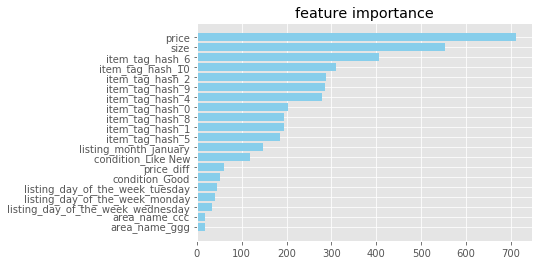

In [47]:
#変数の重要度を取得し、重要な順にトップ20を表示
importances = gbm_model_top_1.feature_importance()
feature_names = df_X_train.columns

selected_num = 20

idx = np.argsort(importances)[::-1][:selected_num]

#変数の重要度をグラフに描画
plt.barh(range(selected_num), importances[idx][::-1], color = 'skyblue', align = 'center')
plt.yticks(range(selected_num), feature_names[idx][::-1])
plt.title("feature importance")
plt.show()

上記結果から、price, size, item_tag_hashでほぼ決まっています。ただし特徴選択を行って特徴量を20個まで絞ったところ、price, size, item_tag_hashが残っているにも関わらず精度が落ちたため、上位にきていない変数は他の変数との組合せ効果（交互作用）によって精度に影響を与えている可能性があります。（LightGBMは決定木ベースのアルゴリズムなので交互作用の効果が考慮されたモデルになっています）

# 5. ラベル推定

In [48]:
#学習データの列名取得
train_columns = df_X_train.columns
print(train_columns)

Index(['price', 'size', 'price_diff', 'area_name_bbb', 'area_name_ccc',
       'area_name_ddd', 'area_name_eee', 'area_name_fff', 'area_name_ggg',
       'area_name_hhh', 'area_name_jjj', 'area_name_kkk', 'condition_Good',
       'condition_Like New', 'listing_hour_morning', 'listing_hour_afternoon',
       'listing_hour_night', 'listing_month_january',
       'listing_day_of_the_week_monday', 'listing_day_of_the_week_saturday',
       'listing_day_of_the_week_sunday', 'listing_day_of_the_week_tuesday',
       'listing_day_of_the_week_tursday', 'listing_day_of_the_week_wednesday',
       'item_tag_hash_0', 'item_tag_hash_1', 'item_tag_hash_2',
       'item_tag_hash_4', 'item_tag_hash_5', 'item_tag_hash_6',
       'item_tag_hash_8', 'item_tag_hash_9', 'item_tag_hash_10'],
      dtype='object')


In [54]:
#検証用データ読みこみ
data_test = pd.read_csv(file_path_test, parse_dates = ['listing_at'], encoding = 'utf-8')

print('テストデータ変換前')
print('{}行、{}列'.format(data_test.shape[0], data_test.shape[1]))
display(data_test.head())
#訓練データのカラム一覧はtrain_columns

#訓練時と同じ変換処理実施
#price_diff作成
data_test['price_diff'] = data_test['sold_price'] - data_test['price']
data_test.drop(['sold_price'], axis = 1, inplace = True)


#日付データ特徴抽出
data_test['listing_hour'] = data_test['listing_at'].map(lambda x : x.hour)
data_test['listing_month'] = data_test['listing_at'].map(lambda x : x.month)
data_test['listing_day_of_the_week'] = data_test['listing_at'].map(lambda x : x.weekday())

#listing_at列は削除
data_test.drop(['listing_at'], axis = 1, inplace = True)

#feature hashing
#訓練時に使用したものと同じインスタンスを使用することに注意
hash_arr = hasher.transform(data_test['item_tag_hash']).toarray()

col_names = []
for i in range(hash_arr.shape[1]):
    col_name = 'item_tag_hash_{}'.format(i)
    col_names.append(col_name)
df_hash = pd.DataFrame(hash_arr, columns = col_names)

data_test = pd.concat([data_test, df_hash], axis = 1)

#時間帯のビン化する
listing_hour_bin = pd.cut(data_test['listing_hour'], bins = [0, 6, 12, 18, 24], labels = ['midnight', 'morning', 'afternoon', 'night'])

data_test['listing_hour'] = listing_hour_bin


#ダミー変数化した際に変数名を判別しやすくするために、カテゴリ名変換
mapping_dict_month = {1: 'january', 2:'february'}
mapping_dict_day_of_the_week = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'tursday', 4: 'friday', 5: 'saturday', 6: 'sunday'}
data_test['listing_month'] = data_test['listing_month'].map(mapping_dict_month)
data_test['listing_day_of_the_week'] = data_test['listing_day_of_the_week'].map(mapping_dict_day_of_the_week)

#ダミー変数化する変数名指定
get_dummy_col = ['area_name', 'condition', 'listing_hour', 'listing_month', 'listing_day_of_the_week']
data_test = pd.get_dummies(data_test, drop_first = True, columns = get_dummy_col)

#item_id列は推定結果のCSV出力時に使用するので別オブジェクトとして保持
s_item_id = data_test['item_id']

#不要な列の削除
data_test.drop(['category_class', 'item_id', 'item_tag_hash','item_tag_hash_3', 'item_tag_hash_7'], axis = 1, inplace = True)

#学習時と同一変数になっていること確認
if set(data_test.columns) != set(train_columns):
    raise ValueError('モデル学習時と異なる変数が存在します')

#訓練データの列順に並び替え
data_test = data_test.loc[:, train_columns]
print('テストデータ変換後')
print('{}行、{}列'.format(data_test.shape[0], data_test.shape[1]))
display(data_test.head())

#テストデータ作成完了
X_test = data_test.values


テストデータ変換前
300行、9列


,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,6000,NaN,1006,1006,aaa,Like New,4,2017-02-01 13:13:59.048372,dd01903921ea24941c26a48f2cec24e0bb0e8cc7
1,5532,NaN,1149,1147,fff,Fair,3,2017-02-01 08:19:21.532519,784e9240155834852dff458a730cceb50229df32
2,6797,NaN,1044,1042,ddd,Like New,21,2017-02-02 13:27:40.620084,7c9fe6831f52e30e0ede4f8c54fd9bba673e8d8b
3,3325,NaN,1547,1545,kkk,Like New,20,2017-02-02 20:59:30.470107,54c1792c99a96a96a2881600f0cce1d81061e8b8
4,5447,NaN,1015,1014,ddd,Like New,5,2017-01-30 17:43:31.962058,081be7c370bf9e7b4c6e696276c1b2d57623b26b


テストデータ変換後
300行、33列


,price,size,price_diff,area_name_bbb,area_name_ccc,area_name_ddd,area_name_eee,area_name_fff,area_name_ggg,area_name_hhh,area_name_jjj,area_name_kkk,condition_Good,condition_Like New,listing_hour_morning,listing_hour_afternoon,listing_hour_night,listing_month_january,listing_day_of_the_week_monday,listing_day_of_the_week_saturday,listing_day_of_the_week_sunday,listing_day_of_the_week_tuesday,listing_day_of_the_week_tursday,listing_day_of_the_week_wednesday,item_tag_hash_0,item_tag_hash_1,item_tag_hash_2,item_tag_hash_4,item_tag_hash_5,item_tag_hash_6,item_tag_hash_8,item_tag_hash_9,item_tag_hash_10
0,1006,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,-4.0,2.0,-5.0,0.0,3.0,-2.0,5.0,-2.0,3.0
1,1147,3,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-4.0,2.0,3.0,0.0,2.0,-1.0,5.0,2.0,1.0
2,1042,21,2,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,-2.0,3.0,0.0,-2.0,2.0,2.0,1.0,3.0,5.0
3,1545,20,2,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,-1.0,1.0,-3.0,2.0,5.0,1.0,2.0,-4.0,-3.0
4,1014,5,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,-1.0,1.0,-2.0,-6.0,2.0,9.0,4.0,-1.0,4.0


In [55]:
#top1~top5のそれぞれのモデルの予測確率取得
pred_proba_top1 = gbm_model_top_1.predict(X_test)
pred_proba_top2 = gbm_model_top_2.predict(X_test)
pred_proba_top3 = gbm_model_top_3.predict(X_test)
pred_proba_top4 = gbm_model_top_4.predict(X_test)
pred_proba_top5 = gbm_model_top_5.predict(X_test)

#平均して最終的な予測結果を算出
pred_proba_all_test = (pred_proba_top1 + pred_proba_top2 + pred_proba_top3 + pred_proba_top4 + pred_proba_top5) / 5 
y_pred_test = np.argmax(pred_proba_all_test, axis = 1)
print()
print('テストデータ予測結果\n', y_pred_test)
print()
print('テストデータ予測結果における各カテゴリの比率\n', pd.Series(y_pred_test).value_counts().sort_index() / len(y_pred_test))
print()
print('訓練データにおける各カテゴリの構成比率\n', data_train['category_class'].value_counts().sort_index() / data_train.shape[0])


テストデータ予測結果
 [0 0 3 1 0 0 4 0 0 3 4 0 2 3 0 2 3 1 0 2 2 0 0 0 0 2 2 4 0 4 4 1 2 0 1 4 2
 3 0 2 2 2 3 2 1 1 3 2 1 0 2 1 1 3 2 0 2 1 0 0 2 0 0 1 1 0 1 0 4 0 4 0 1 3
 0 4 3 0 0 0 0 2 1 0 0 2 0 1 1 0 3 2 1 2 3 2 0 0 2 0 1 2 1 0 4 2 2 1 3 1 0
 0 3 0 2 0 1 0 0 4 0 0 0 2 0 0 0 0 2 0 0 0 0 3 2 2 2 3 0 2 4 0 3 2 2 4 3 1
 0 0 0 2 2 3 0 1 1 1 0 0 0 3 1 4 0 2 4 1 2 4 0 0 2 0 3 1 0 0 3 1 4 2 3 2 1
 0 1 1 0 0 3 1 1 4 1 4 1 2 4 2 1 2 4 2 0 0 0 3 0 4 2 0 1 1 2 1 2 2 4 0 2 3
 1 2 4 2 3 1 0 1 0 0 1 2 1 4 1 1 2 0 4 1 0 2 0 1 3 0 0 1 1 2 0 1 1 2 2 4 3
 2 1 1 0 0 4 2 2 0 3 1 0 4 0 4 4 2 1 0 2 1 2 1 1 0 2 2 0 2 2 3 2 2 3 0 1 0
 3 1 4 1]

テストデータ予測結果における各カテゴリの比率
 0    0.330000
1    0.216667
2    0.236667
3    0.110000
4    0.106667
dtype: float64

訓練データにおける各カテゴリの構成比率
 0    0.322857
1    0.212857
2    0.224286
3    0.122857
4    0.117143
Name: category_class, dtype: float64


以下訓練データ、テストデータが適切にサンプリングされている前提です。この前提を置くならテストデータ予測結果における各カテゴリの構成比率は訓練データのカテゴリ構成比率に近くなるはずです。比較すると、近しい構成比率になっていますが、カテゴリ2,3,4はやや比率の差が大きく、0,1に比べると誤判定が多いかもしれません。

推定結果CSV出力

In [57]:
df_result = pd.DataFrame({'item_id': s_item_id, 'category_class': y_pred_test})
print(df_result.shape)

(300, 2)


In [58]:
df_result.head()

,item_id,category_class
0,6000,0
1,5532,0
2,6797,3
3,3325,1
4,5447,0


In [59]:
df_result.to_csv('predict_result.csv', encoding = 'utf-8', index = False)

### 解答は以上です